# Code

In [3]:
from ps_estimator import pstimator 
import bandpowers
import utils

In [4]:
import numpy as np
import pymaster as nmt
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt 
import imp
import camb

from astropy.io import fits as fits

from scipy.linalg import sqrtm

from numpy import linalg as LA
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [109]:
from dynesty import utils as dyfunc 

In [34]:
from multiprocessing import Pool, cpu_count

In [5]:
nside = 128
nmtlmax = 201
lmin = 2
lmax = 1521

In [6]:
SamNum = 500

In [7]:
Nf = 2

nf_ind = int(Nf*(Nf+1)/2)

In [837]:
b = nmt.NmtBin(nside, nlb=20, is_Dell=True, lmax=nmtlmax)  ### 2020.08.01 
leff = b.get_effective_ells()
lbin = len(leff)
b_ind = np.arange(1,lbin+1)

In [9]:
ali_ma = hp.read_map('/fnx/jianyao/Likelihood_data/ABSData/ali_mask.fits', field = None)

NSIDE = 128
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


## window function

 equal weight for each $\ell$ in a $\ell$-bin
 
 for bin_width = 20, weight = 1/20 = 0.05

### code

In [45]:
b = nmt.NmtBin(nside, nlb=20, is_Dell=True, lmax=nmtlmax)
leff = b.get_effective_ells()
nb = len(leff)
for i in range(nb):

    bpwf = np.zeros(lmax-lmin+2)
    lrange = b.get_ell_list(i)
    w = b.get_weight_list(i) ## weights for each ell in i-th bin
    bpwf[lrange-lmin+1] = w
    l = np.arange(1, lmax-lmin+3)

    bpwf = np.array([l, bpwf]).T
    
    # print(np.shape(bpwf))
    # np.savetxt(data_dir+'AliCPT_bpwf_bin%s.txt'%(i+1), bpwf, fmt=['%d', '%.10e', '%.10e', '%.10e'])
    # np.savetxt(data_dir + 'AliCPT_bpwf_bin%s.txt' % (i + 1), bpwf, fmt=['%d', '%.10e', '%.10e', '%.10e', '%.10e', '%.10e', '%.10e'])
#     np.savetxt(data_dir+'AliCPT_bpwf_bin%s.txt'%(i+1), bpwf, fmt=['%d', '%.10e'])

## 2fre-full-sky-data

BB cross-frequency bandpower spectra

- Cl_hat : (lbin, Nf, Nf)

- Cl_f :  ((lbin, Nf, Nf))

- Cl_th : ((lbin, Nf, Nf))


In [859]:
## cl_fiducial
cl_f_all = np.load('/fnx/jianyao/Likelihood_data/Bandpowers/0627_2fre_fullsky/cl_f_all.npy')
cl_f = np.mean(cl_f_all, axis = 0)

In [861]:
cl_f.shape

(3, 10, 2, 2)

In [1100]:
## cl_th

cl_camb = np.load('/fnx/jianyao/Likelihood_data/Bandpowers/0627_2fre_fullsky/cl_camb_BB_2fre.npy')

nl_all = np.load('/fnx/jianyao/Likelihood_data/Bandpowers/0627_2fre_fullsky/nl_all.npy')
nl_mean = np.mean(nl_all, axis = 0) ## EE EB BB

cl_th_BB = cl_camb + nl_mean[2]

In [856]:
### 观测数据应该只有一幅。。。

cl_hat_all = np.load('/fnx/jianyao/Likelihood_data/Bandpowers/0627_2fre_fullsky/cl_hat_all.npy')
cl_hat = np.mean(cl_hat_all, axis = 0)
cl_hat_0 = cl_hat_all[1]

In [1082]:
print('Cl_hat:',cl_hat_0.shape,'\n'
'Cl_f:',cl_f.shape,'\n'
'Cl_th_BB:',cl_th_BB.shape)

Cl_hat: (3, 10, 2, 2) 
Cl_f: (3, 10, 2, 2) 
Cl_th_BB: (10, 2, 2)


$$\left(X_b^{30*30}, X_b^{95*95}, X_b^{150*150}, X_b^{353*353}, X_b^{30*95}, X_b^{95*150},X_b^{150*353},X_b^{30*150},X_b^{95*353},X_b^{30*353} \right)=\textrm{vecp}\left((\mathcal{D}_b^f)^{1/2}{\bf U}_b\,g({\bf D}_b){\bf U}_b^{\dagger}(\mathcal{D}_b^f)^{1/2}\right)$$

In [1070]:
#(cl_hat_all, nf_ind, Nmode,lbin, SamNum)

marry = utils.Marray_EEfirst(cl_f_all, nf_ind, 3, lbin, cl_f_all.shape[0]) ## (Nmode*lbin*nf_ind, SamNum)

cov_mat_BB = np.cov(marry[lbin*nf_ind*2:]) ##(select BB mode)

M_inv = utils.Minv(cov_mat_BB, lbin, nf_ind)

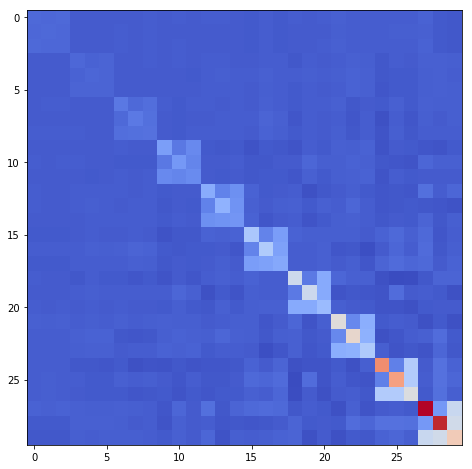

In [1138]:
plt.figure(figsize = (10, 8))
plt.imshow(cov_mat_BB, cmap = 'coolwarm')

## 2-fre Ali-sky

### cl_f, r=0.05

In [296]:
path = '/fnx/jianyao/Likelihood_data/Bandpowers/0629_2fre_Ali'

cl_f_all_ali = np.load('%s/cl_f_all.npy'%path); cl_f_ali = np.mean(cl_f_all_ali, axis = 0)

cl_hat_all_ali = np.load('%s/cl_hat_all.npy'%path)
cl_hat_0_ali = cl_hat_all_ali[2]

nl_all_ali = np.load('%s/nl_all.npy'%path)
nl_mean_ali = np.mean(nl_all_ali, axis = 0) ## EE EB BB

In [288]:
cl_camb = np.load('/fnx/jianyao/Likelihood_data/Bandpowers/0627_2fre_fullsky/cl_camb_BB_2fre.npy')
cl_th_BB_ali = cl_camb + nl_mean_ali[2]

In [297]:
marry_ali = utils.Marray_EEfirst(cl_f_all_ali, nf_ind, 3, lbin, cl_f_all_ali.shape[0]) ## (Nmode*lbin*nf_ind, SamNum)

cov_mat_BB_ali = np.cov(marry_ali[lbin*nf_ind*2:]) ##(select BB mode)

M_inv_ali = utils.Minv(cov_mat_BB_ali, lbin, nf_ind)

### cl_f, r = 0.01; 2020/07/01

In [1321]:
cl_f_all_ali_0p01 = np.load('/fnx/jianyao/Likelihood_data/Bandpowers/0629_2fre_Ali/cl_f_0p01_all.npy')
cl_f_ali_0p01 = np.mean(cl_f_all_ali_0p01, axis = 0)

In [1322]:
marry_ali_0p01 = utils.Marray_EEfirst(cl_f_all_ali_0p01, nf_ind, 3, lbin, cl_f_all_ali_0p01.shape[0]) ## (Nmode*lbin*nf_ind, SamNum)

cov_mat_BB_ali_0p01 = np.cov(marry_ali_0p01[lbin*nf_ind*2:]) ##(select BB mode)

M_inv_ali_0p01 = utils.Minv(cov_mat_BB_ali_0p01, lbin, nf_ind)

In [1324]:
Nreal = 50
### begin with the first bin, which may encounter negative eiven-values sometime.
r_rec_ali_0p01 = np.ones(Nreal)
for i in range(Nreal):
    r_rec_ali_0p01[i] = r_like(cl_hat_all_ali[i], cl_f_ali_0p01, nl_mean_ali, M_inv_ali_0p01, sbin = 1)

In [1326]:
np.mean(r_rec_ali_0p01)

0.050658

In [1327]:
np.mean(r_rec_ali)

0.05088400000000001

In [1329]:
np.std(r_rec_ali)

0.0029464799337514586

In [1330]:
np.std(r_rec_ali_0p01)

0.003415967798443071

Text(0.5, 0, 'Tensor-to-scalar ratio $r$')

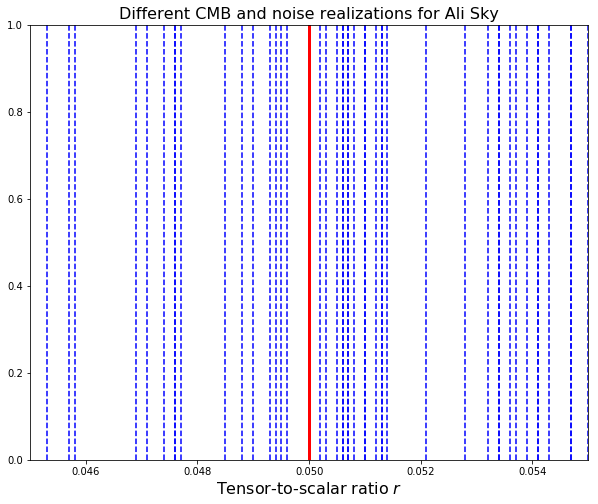

In [1328]:
plt.figure(figsize = (10, 8))
for i in range(Nreal):
    plt.axvline(r_rec_ali_0p01[i],c='b', ls='--')
plt.xlim(0.045, 0.055)

plt.axvline(0.05, c='r', lw = 3,ls='-')
plt.title('Different CMB and noise realizations for Ali Sky', fontsize = 16)
plt.xlabel(r'Tensor-to-scalar ratio $r$', size=16)

In [1285]:
nl_mean.shape

(3, 10, 2, 2)

In [1289]:
evaluateL = utils.evaluateLikelihood

def r_like(cl_hat_0, cl_f, nl_mean, M_inv, sbin):
# Initiating the logarithmic likelihood arrays
    logLike = np.zeros(len(rlist))

    # loop over r values
    for i in range(len(rlist)):

        r_i  =  rlist[i]
        bb_tensor = bb_05[0:nmtlmax+1]*r_i/0.05 

        bb_camb = bb_tensor + lensingB[2][0:nmtlmax+1] ## tensor BB + lensing BB 

        cl_th_i = b.bin_cell(bb_camb[0:nmtlmax+1])  ## theoretical bandpower 
        cl_th_test = np.ones((lbin, Nf, Nf));  ## BB cross power spectra
        for ell in range(lbin):
            cl_th_test[ell] *= cl_th_i[ell]

        # add Noise bias N_l to expectation values.
        C_l = cl_th_test + nl_mean[2]

        logL = evaluateL(C_l, cl_hat_0[2], cl_f[2], M_inv, sbin)
        logLike[i] = np.real(logL)
    
    r_max = np.argsort(logLike)[-1]
    return rlist[r_max]

In [1290]:
Nreal = 50
### begin with the first bin, which may encounter negative eiven-values sometime.
r_rec_ali_0bin = np.ones(Nreal)
for i in range(Nreal):
    r_rec_ali_0bin[i] = r_like(cl_hat_all_ali[i], cl_f_ali, nl_mean_ali, M_inv_ali, sbin = 0)

/home/jianyao/Likelihood/utils.py:55: RuntimeWarning: invalid value encountered in log
  gd = np.sign(np.diag(d) - 1) * np.sqrt(2 * (np.diag(d) - np.log(np.diag(d)) - 1))


In [1303]:
for i in range(Nreal):
    print(LA.eigvals(cl_hat_all_ali[i][2][0]))

[0.00289777 0.00029402]
[0.00136805 0.00092418]
[0.00329711 0.00016062]
[0.00323808 0.00032465]
[0.00609118 0.00057367]
[0.00293192 0.00117498]
[1.09151197e-03 1.15780299e-05]
[0.00114612 0.00013751]
[0.00047411 0.00752107]
[0.00399521 0.00027286]
[0.00075935 0.00026439]
[-2.81299057e-05  6.43173527e-03]
[3.53613840e-05 5.17467343e-03]
[-6.56753478e-05  2.26924254e-03]
[-0.00011945  0.0017162 ]
[0.00202027 0.0001356 ]
[ 3.01095699e-03 -6.25213620e-05]
[0.00025225 0.00315406]
[0.00170123 0.00052035]
[-0.0001134   0.00067347]
[0.00428753 0.00059694]
[1.52142448e-05 1.20057576e-04]
[0.00235357 0.00137886]
[ 0.00046258 -0.00014552]
[0.00025125 0.01120999]
[2.29834408e-03 5.81058047e-05]
[-0.00019415  0.00114606]
[0.00052818 0.00045962]
[0.00031446 0.00278454]
[0.00109901 0.00032158]
[0.00072347 0.00028649]
[1.08318652e-03 4.25340185e-05]
[3.66150034e-03 5.10030565e-05]
[0.00252894 0.0004881 ]
[-6.91646416e-05  3.65205179e-03]
[0.00180813 0.00064303]
[0.00288896 0.00011457]
[0.00024194 0.00

In [1304]:
r_like(cl_hat_all_ali[11], cl_f_ali, nl_mean_ali, M_inv_ali, sbin = 0)

/home/jianyao/Likelihood/utils.py:55: RuntimeWarning: invalid value encountered in log
  gd = np.sign(np.diag(d) - 1) * np.sqrt(2 * (np.diag(d) - np.log(np.diag(d)) - 1))


0.0999

In [1292]:
r_rec_ali_0bin

array([0.05  , 0.0527, 0.0487, 0.0514, 0.0485, 0.0541, 0.0503, 0.0556,
       0.0464, 0.0498, 0.05  , 0.0999, 0.0518, 0.0999, 0.0999, 0.0508,
       0.0999, 0.0503, 0.051 , 0.0999, 0.0554, 0.0502, 0.0483, 0.0999,
       0.0476, 0.0534, 0.0999, 0.0557, 0.0504, 0.0528, 0.0545, 0.0536,
       0.0464, 0.0495, 0.0999, 0.05  , 0.051 , 0.0475, 0.0532, 0.0463,
       0.0469, 0.0532, 0.0525, 0.0532, 0.049 , 0.0541, 0.0999, 0.0571,
       0.0999, 0.0511])

Text(0.5, 0, 'Tensor-to-scalar ratio $r$')

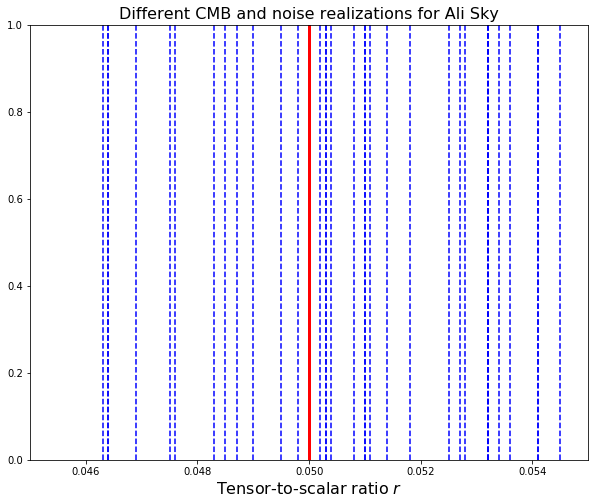

In [1295]:
plt.figure(figsize = (10, 8))
for i in range(Nreal):
    plt.axvline(r_rec_ali_0bin[i],c='b', ls='--')
plt.xlim(0.045, 0.055)

plt.axvline(0.05, c='r', lw = 3,ls='-')
plt.title('Different CMB and noise realizations for Ali Sky', fontsize = 16)
plt.xlabel(r'Tensor-to-scalar ratio $r$', size=16)

In [1312]:
Nreal = 50

r_rec_ali = np.ones(Nreal)
for i in range(Nreal):
    r_rec_ali[i] = r_like(cl_hat_all_ali[i], cl_f_ali, nl_mean_ali, M_inv_ali, sbin = 1)

In [1277]:
print('Ali', np.mean(r_rec_ali),
np.std(r_rec_ali), '\n',
    
'full_sky',
np.mean(r_rec),
np.std(r_rec))

Ali 0.05087200000000001 0.0029419748469353036 
 full_sky 0.05000999999999999 0.0010577806956075537


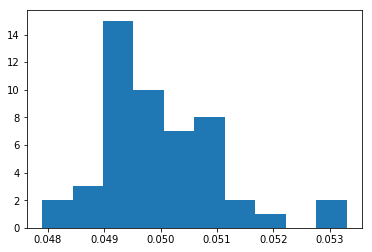

In [1264]:
plt.hist(r_rec)
plt.savefig('./fig_results/0630_histgram_full_sky.pdf', format = 'pdf')

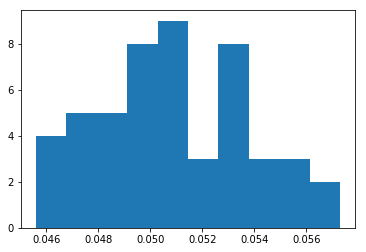

In [1318]:
plt.hist(r_rec_ali, bins=10)
plt.savefig('./fig_results/0630_histgram_ali_sky.pdf', format = 'pdf')

Text(0.5, 0, 'Tensor-to-scalar ratio $r$')

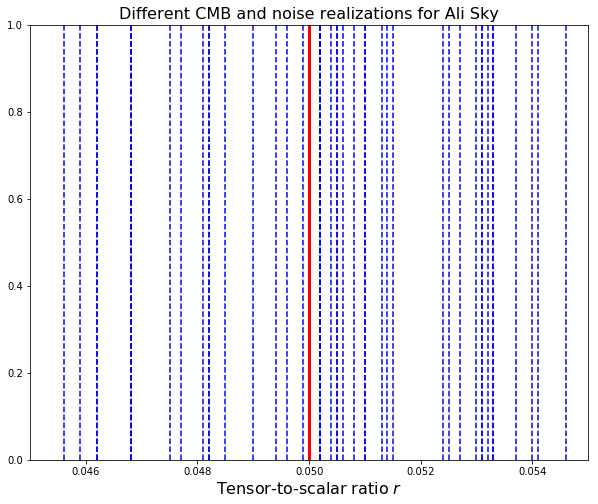

In [1313]:
plt.figure(figsize = (10, 8))
for i in range(Nreal):
    plt.axvline(r_rec_ali[i],c='b', ls='--')
plt.xlim(0.045, 0.055)

plt.axvline(0.05, c='r', lw = 3,ls='-')
plt.title('Different CMB and noise realizations for Ali Sky', fontsize = 16)
plt.xlabel(r'Tensor-to-scalar ratio $r$', size=16)
# plt.savefig('./fig_results/0630_constrains_on_r_Ali_sky_different_realizations.pdf', format = 'pdf')

## Bandpower covariance matrix

10 bins, 10-fre cross, SamNum BB

> /home/yao/Desktop/likelihood/ali_joint_analysis/CosmoMC_AliCPT/data/AliCPT_Plk/AliCPT_covmat.dat

$234 \times 234$

(39x6) * (39x6)

39-bin; bin_width = 20, nmtlmax = 800 

Ali_95_BxAli_95_B Ali_95_BxAli_150_B Ali_95_BxAli_353_B Ali_150_BxAli_150_B Ali_150_BxAli_353_B Ali_353_BxAli_353_B

### Get arrays for Covariance matrix

In [1073]:
def Marray_lfirst(cl_f_all, nf_ind, Nmode,lbin, SamNum):
    
    '''
    Input
    --------------------------------
    nf_ind : number of independent frequencies cross
    Nmode: number of modes, e.g., EE,EB,BB
    SamNum: number of realizations
    cl_hat_all: cl_hat that consists of all the realizations (20, 3, 10, 4, 4);(SamNum, Nmode, lbin, Nf, Nf)
    
    Output
    --------------------------------
    
    '''  
    vecp = utils.vecp
    marray = np.zeros(((lbin*Nmode*nf_ind), SamNum)) # mode(EE, EB, BB), l-bin, nf independent corr between frequencies 
    for n in range(SamNum):

        for ell in range(lbin):

            cl_flat = np.zeros((Nmode, nf_ind)) ## collect independent corr for each mode

            for mode in range(Nmode):

                cl_flat[mode] = vecp(cl_f_all[n][mode][ell])

            marray[ell*Nmode*nf_ind:(ell+1)*Nmode*nf_ind,n] = cl_flat.flatten()
    
    return marray

In [984]:
vecp = utils.vecp

In [1072]:
def Marray_EEfirst(cl_f_all, nf_ind, Nmode,lbin, SamNum):

    marray = np.zeros(((Nmode*lbin*nf_ind), SamNum)) # mode(EE, EB, BB), l-bin, nf independent corr between frequencies 
    for n in range(SamNum):

        for mode in range(Nmode):    

            cl_flat = np.zeros((lbin, nf_ind)) ## collect independent corr for each l-bin

            for ell in range(lbin):
                cl_flat[ell] = vecp(cl_f_all[n][mode][ell])# - nl_mean[2][ell] ) ##########!!!!!!!!!!!!!!!!!! need to subtract noise?? 06.27

            marray[mode*lbin*nf_ind:(mode+1)*lbin*nf_ind,n] = cl_flat.flatten()
            
    return marray

### Figures

In [116]:
marry = Marray_EEfirst(4, 3, 10, cl_hat_all.shape[0], cl_hat_all)

In [1278]:
# cov_marry = np.corrcoef(marry)
# plt.figure(figsize = (10,10))
# plt.imshow(cov_marry, cmap = 'coolwarm', vmin = -1, vmax = 1)
# plt.colorbar()
# plt.title('lbin , mode, frequency (10*3*10)', fontsize = 20)
# plt.savefig('./fig_results/covariance_matrix_lbin_first.pdf', format = 'pdf')

In [1280]:
# cov_marry = np.corrcoef(marry)
# plt.figure(figsize = (10,10))
# plt.imshow(cov_marry, cmap = 'coolwarm', vmin = -1, vmax = 1)
# plt.colorbar()
# plt.title('mode , lbin, frequency', fontsize = 20)
# plt.annotate(s = '',xy=(0.07,0.08), xytext=(0.33,0.08),arrowprops=dict(arrowstyle='<->'), xycoords = 'figure fraction')
# plt.annotate(s = '',xy=(0.33,0.08), xytext=(0.59,0.08),arrowprops=dict(arrowstyle='<->'), xycoords = 'figure fraction')
# plt.annotate(s = '',xy=(0.585,0.08), xytext=(0.84,0.08),arrowprops=dict(arrowstyle='<->'), xycoords = 'figure fraction')
# plt.text(45, 340, 'EE', fontsize = '15')
# plt.text(145, 340, 'EB', fontsize = '15')
# plt.text(245, 340, 'BB', fontsize = '15')

# plt.annotate(s = '',xy=(0.07,0.125), xytext=(0.105,0.125),arrowprops=dict(arrowstyle='<->'), xycoords = 'figure fraction')
# plt.annotate(s = '',xy=(0.105,0.125), xytext=(0.140,0.125),arrowprops=dict(arrowstyle='<->'), xycoords = 'figure fraction')

# plt.text(0, 320, '$\ell$1', fontsize = '15')
        
# plt.text(12, 320, '$\ell$2', fontsize = '15')
          
# plt.savefig('./fig_results/covariance_matrix_EE_first.pdf', format = 'pdf')

In [1281]:
# ## 20 realizations

# plt.figure(figsize = (10,10))
# plt.imshow(cov_mat_BB, cmap = 'coolwarm', vmin = -1, vmax = 1)
# plt.colorbar()

In [489]:
marry.shape

(300, 500)

In [33]:
cov_mat =  np.corrcoef(marray)## full covariance matrix
# 
# np.corrcoef(marray)

In [1282]:
# plt.figure(figsize = (10,10))
# plt.imshow(cov_mat, cmap = 'coolwarm', vmin = -1, vmax = 1)
# plt.colorbar()
# # plt.text(0,-5,'EE')
# # plt.xticks([100], 'hh')
# # plt.xlim(-10, 310)
# # plt.ylim(-10, 310)

# plt.annotate(s = '',xy=(0.07,0.08), xytext=(0.33,0.08),arrowprops=dict(arrowstyle='<->'), xycoords = 'figure fraction')
# plt.annotate(s = '',xy=(0.33,0.08), xytext=(0.59,0.08),arrowprops=dict(arrowstyle='<->'), xycoords = 'figure fraction')
# plt.annotate(s = '',xy=(0.585,0.08), xytext=(0.84,0.08),arrowprops=dict(arrowstyle='<->'), xycoords = 'figure fraction')
# plt.text(45, 340, 'EE', fontsize = '15')
# plt.text(145, 340, 'EB', fontsize = '15')
# plt.text(245, 340, 'BB', fontsize = '15')

# plt.annotate(s = '',xy=(0.07,0.125), xytext=(0.105,0.125),arrowprops=dict(arrowstyle='<->'), xycoords = 'figure fraction')
# plt.annotate(s = '',xy=(0.105,0.125), xytext=(0.140,0.125),arrowprops=dict(arrowstyle='<->'), xycoords = 'figure fraction')

# plt.text(0, 320, '$\ell$1', fontsize = '15')
# plt.text(12, 320, '$\ell$2', fontsize = '15')

### calculate the covariance matrix

### reorganize M_inv to (lbin, lbin, nf_ind, nf_ind)for the Likelihood calculation 

##### for EE first

In [557]:
cov_mat_inv = LA.inv(cov_mat_BB)
M_inv = np.ones((lbin, lbin, nf_ind, nf_ind))

### for EE first

for ell in range(lbin*nf_ind):
    i = ell//10; j = ell%10;
    for fre in range(nf_ind):
        
        M_inv[i, j] = np.triu(cov_mat_inv[ell, nf_ind*fre:nf_ind*(fre+1)])
        
## only BB

##### for l-bin first

In [1057]:
M_inv = utils.Minv(cov_mat_BB, lbin, nf_ind)

### Test for  Likelihood

#### BB mode

In [2243]:
bb = GenBB(0.05, raw_cl=True)
bb_06 = GenBB(0.06, raw_cl=True)

/home/jianyao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


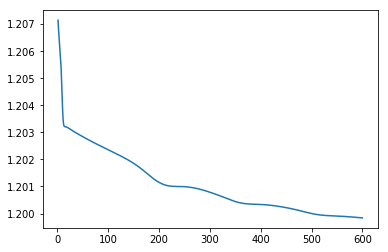

In [2244]:
plt.plot(bb_06/bb)

In [691]:
nl_mean[2][:,1,1]

array([0.00219406, 0.00042306, 0.0008092 , 0.00138481, 0.0021608 ,
       0.00313533, 0.00429503, 0.00563341, 0.00718524, 0.00949875])

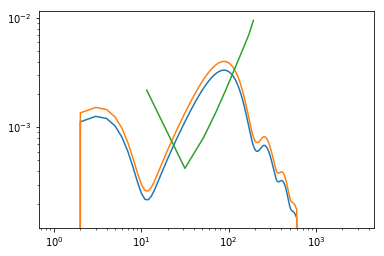

In [697]:
# plt.loglog(total[:,2])
plt.loglog(bb)
plt.loglog(bb_06)

plt.loglog(est.ell_n, nl_mean[2][:,1,1])

#### evaluate L 

def evaluateLikelihood(C_l,C_l_hat,C_fl,M_inv)

In [1168]:
rlist = np.arange(0, 0.1, 0.0001)

In [1309]:
Nreal = 50

r_rec = np.ones(Nreal)
for i in range(Nreal):
    r_rec[i] = r_like(cl_hat_all[i], cl_f, nl_mean, M_inv, sbin = 0)

In [1256]:
np.std(r_rec)

0.0010577806956075537

In [1200]:
np.mean(r_rec)

0.05000999999999999

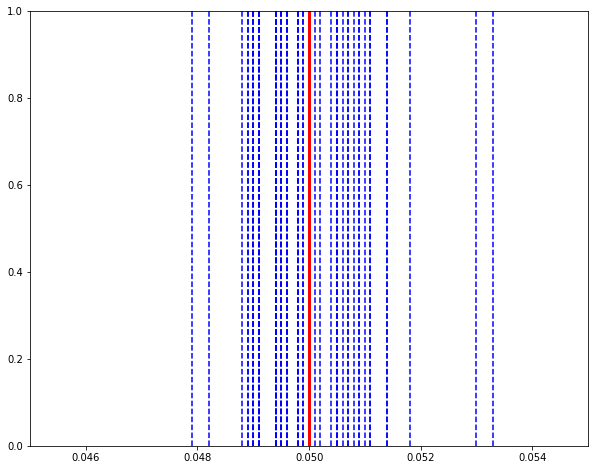

In [1262]:
plt.figure(figsize = (10, 8))
for i in range(Nreal):
    plt.axvline(r_rec[i],c='b', ls='--')
plt.xlim(0.045, 0.055)

plt.axvline(0.05, c='r', lw = 3,ls='-')
plt.savefig('./fig_results/0630_constrains_on_r_full_sky_different_realizations.pdf', format = 'pdf')

In [1257]:
rlist[548] - rlist[530]

0.001799999999999996

Text(0.5, 1.0, 'Constraints on $r$ for full-sky')

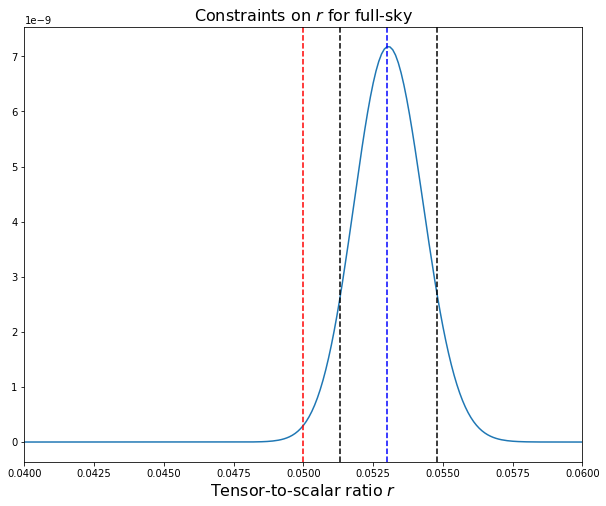

In [1176]:
plt.figure(figsize = (10, 8))
plt.plot(rlist, np.exp(logLike))
# plt.yscale('log')
plt.axvline(0.05, c='r', ls='--')

plt.axvline(rlist[513], c='k', ls='--')

plt.axvline(rlist[548], c='k', ls='--')

plt.axvline(rlist[530], c='b', ls='--')

plt.xlim([0.04, 0.06])
# plt.ylim([0, 0.07])
# plt.yticks([])
plt.xlabel(r'Tensor-to-scalar ratio $r$', size=16)
# plt.ylabel(r'Probability', size=16)
plt.title(r'Constraints on $r$ for full-sky', size=16)
# plt.text(0.052, 1.0, 'r = 0.05', fontsize = 20)

# plt.savefig('./fig_results/constraints_on_r_full_sky.pdf', format = 'pdf')

## $\chi^2$ test

In [1225]:
r_like(cl_hat_all[1], cl_f, nl_mean, M_inv)

0.053000000000000005

In [1227]:
cmb_1 = np.load('/fnx/jianyao/Likelihood_data/Simulations/CMB/cmb_maps_mc_%03d.npy'%1)

In [1240]:
ell = np.arange(nmtlmax + 1)

In [1234]:
cls = hp.anafast(cmb_1, lmax = nmtlmax)

In [1241]:
hp.anafast?

In [1238]:
cl_r = utils.Gencl(r = 0.05, raw_cl = False)

In [1244]:
cl_r_53 = utils.Gencl(r = 0.053, raw_cl = False)

(1, 202)

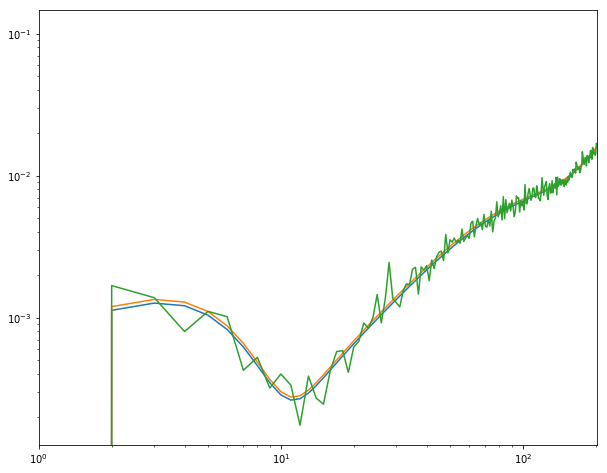

In [1250]:
plt.figure(figsize=(10, 8))
plt.loglog(cl_r[2])
plt.loglog(cl_r_53[2])

plt.loglog(ell, ell*(ell+1)/2/np.pi*cls[2])

plt.xlim(1, nmtlmax+1)

In [1306]:
Nreal = 50

r_rec_0bin = np.ones(Nreal)
for i in range(Nreal):
    r_rec_0bin[i] = r_like(cl_hat_all[i], cl_f, nl_mean, M_inv, sbin=0)

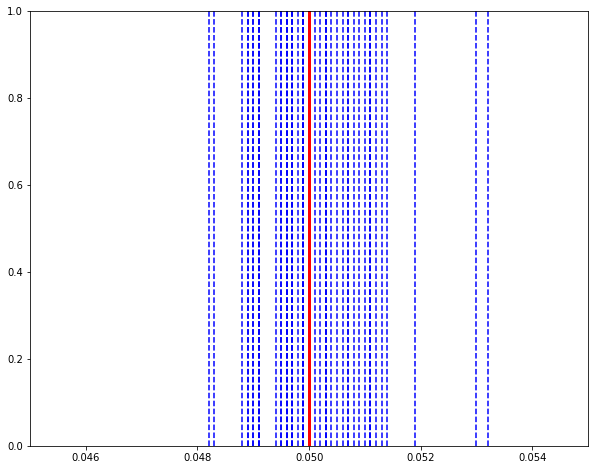

In [1307]:
plt.figure(figsize = (10, 8))
for i in range(Nreal):
    plt.axvline(r_rec_0bin[i],c='b', ls='--')
plt.xlim(0.045, 0.055)

plt.axvline(0.05, c='r', lw = 3,ls='-')

In [1502]:
np.mean(r_rec_ali_0p01)

0.050658

In [1503]:
np.mean(r_rec_ali)

0.05088400000000001

## dynesty

In [73]:
imp.reload(modified_likelihood)

<module 'modified_likelihood' from '/home/jianyao/Likelihood/modified_likelihood.py'>

In [72]:
import modified_likelihood
from modified_likelihood import testL_sub as testL_sub

In [65]:
from utils import testL as testL

In [857]:
import Fg_template
imp.reload(Fg_template)

<module 'Fg_template' from '/home/jianyao/Likelihood/Fg_template.py'>

In [858]:
import dynesty
from dynesty import plotting as dyplot
## import planck function 
from pysm.common import B as pf
from Fg_template import sync_ps, dust_ps
from Fg_template import corre_fore_simple

In [843]:
lensingB = utils.Gencl(r = 0, raw_cl = True) ## only lensing BB; TT EE BB TE

bb_05 = utils.Gencl(r = 0.05, raw_cl = True, tensorBB_only=True) ##only tensor BB; ## 

### test for different likelihood

In [793]:
def vecp_real(mat):
    '''
    This returns the unique elements of a symmetric matrix 
    '''
    dim = mat.shape[0]
    
    vec = np.zeros(int(dim*(dim+1)/2))
    counter = 0
    for iDiag in range(0,dim):
        vec[counter:counter+dim-iDiag] = np.diag(mat,iDiag)
        
        counter = counter + dim - iDiag

    return vec

def vecp_jx(mat):
    y = np.triu(mat, k = 0)
    vecp_y = y[y != 0]
    return vecp_y

def calculate_vecp(cl_hat, Nf):
    
    '''
    Turn the matrix into X-form.
    '''
    lbin = len(cl_hat); nf_ind = int(Nf*(Nf+1)/2);
    Xall = np.ones(lbin*nf_ind);
    for l in range(lbin):
        Xall[l*nf_ind:(l+1)*nf_ind] = vecp_real(cl_hat[l])
    
    return(Xall)


##  -2lnL = (C_hat - C)*M^-1*(C_hat - C ^T)
def simple_likelihood(cl_hat,cl_th, Nf, M, sbin = 1):
    
    Xa = calculate_vecp(cl_hat - cl_th, Nf);
    M_inv = LA.inv(M);
    
    if sbin is not None:
        
        nf_ind = int(Nf*(Nf+1)/2)
        start = sbin*nf_ind
        
        Xa = Xa[start:]; 
        M_inv = M_inv[start:,start:]
    
    Xa = np.matrix(Xa);
    
    logL = -0.5*Xa*M_inv*np.transpose(Xa)
    
    return(logL[0,0])

def jx_simple_likelihood(cl_hat,cl_th, Nf, M, sbin = 1):
    
    Xa = calculate_vecp(cl_hat - cl_th, Nf);
#     M_inv = LA.inv(M);
    
    if sbin is not None:
        
        nf_ind = int(Nf*(Nf+1)/2)
        start = sbin*nf_ind
        
        Xa = Xa[start:]; 
#         M_inv = M_inv[start:,start:]
        M = M[start:, start:]
    
#     Xa = np.matrix(Xa);
    
    logL = -0.5*(np.vdot(Xa, np.linalg.solve(M, Xa.T))) 
 
    return(logL[0,0])


In [790]:
simple_likelihood(fl_pysm[2], sync_ps(A_s_RJ, -3.0, lbin) + dust_ps(A_d_RJ, 1.5, lbin) , Nf = Nf, M = cov_mat_BB_ali, sbin = 0)

-9428.857497180437

In [798]:
jx_simple_likelihood(fl_pysm[2], sync_ps(A_s_RJ, -3.0, lbin) + dust_ps(A_d_RJ, 1.5, lbin) , Nf = Nf, M = cov_mat_BB_ali, sbin = 0)

-34.41801220356871

In [830]:
Xa = calculate_vecp(fl_pysm[2] - sync_ps(A_s_RJ, -3.0, lbin) - dust_ps(A_d_RJ, 1.5, lbin), 2)
Xa = np.matrix(Xa)

In [829]:
-0.5*np.vdot(Xa,np.linalg.solve(cov_mat_BB_ali, Xa.T))

-9428.857497180445

### No foreground for Ali Sky

In [2165]:
imp.reload(Fg_template)

<module 'Fg_template' from '/home/jianyao/Likelihood/Fg_template.py'>

In [1949]:
from utils import testL as testL

In [1939]:
def log_lcmb(cube):
    r_i = cube;
    bb_tensor = bb_05[0:nmtlmax+1]*r_i/0.05 

    bb_camb = bb_tensor + lensingB[2][0:nmtlmax+1] ## tensor BB + lensing BB 

    cl_th_i = b.bin_cell(bb_camb[0:nmtlmax+1])  ## theoretical bandpower 
    cl_th_test = np.ones((lbin, Nf, Nf));  ## BB cross power spectra
    for ell in range(lbin):
        cl_th_test[ell] *= cl_th_i[ell]

    # add Noise bias N_l to expectation values.
    C_l = cl_th_test + nl_mean_ali[2]

    logL = testL(cl_hat_all_ali[10][2], cl_f_ali[2], C_l, Nf = Nf, M = cov_mat_BB_ali, sbin = 1)
    
    return np.real(logL)

def prior_cmb(cube):
    r = cube*0.1
   
    return r

In [1902]:
sampler = dynesty.NestedSampler(log_lcmb, prior_cmb, 1, nlive=400)
sampler.run_nested()
results = sampler.results

1541it [00:58, 26.14it/s, +400 | bound: 1 | nc: 1 | ncall: 14618 | eff(%): 13.278 | loglstar:   -inf < -23.042 <    inf | logz: -25.806 +/-  0.084 | dlogz:  0.001 >  0.409]


Quantiles:
$x_{1}$ [(0.025, 0.04566514245807846), (0.5, 0.05031006238732454), (0.975, 0.05582365975366761)]


(<Figure size 864x216 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa32eb542b0>,
       dtype=object))

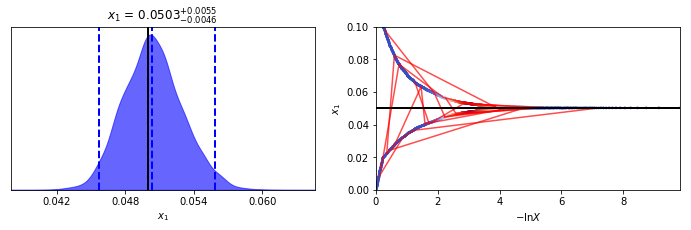

In [1903]:
dyplot.traceplot(results, truths=np.ones(1)*0.050,
                             truth_color='black', show_titles=True,
                             trace_cmap='coolwarm', title_fmt='.4f',connect=True, verbose = True)

### Foreground

In [832]:
path = '/fnx/jianyao/Likelihood_data/Bandpowers/0710_2fre_Ali_real_fore_and_noise'

cl_f_all_ali = np.load('%s/cl_f_all.npy'%path); 
# cl_f_all_ali[:,2] +=  sync_dl_RJ + dust_dl_RJ #
cl_f_ali = np.mean(cl_f_all_ali, axis = 0)

cl_hat_all_ali = np.load('%s/cl_hat_fore_all.npy'%path)
cl_hat_0_ali = cl_hat_all_ali[10]

nl_all_ali = np.load('%s/nl_all.npy'%path)
nl_mean_ali = np.mean(nl_all_ali, axis = 0) ## EE EB BB

In [833]:
lbin = 10

In [834]:
marry_ali = utils.Marray_EEfirst(cl_f_all_ali, nf_ind, 3, lbin, cl_f_all_ali.shape[0]) ## (Nmode*lbin*nf_ind, SamNum)

cov_mat_BB_ali = np.cov(marry_ali[lbin*nf_ind*2:]) ##(select BB mode)

M_inv_ali = utils.Minv(cov_mat_BB_ali, lbin, nf_ind)

In [718]:
Xjx = np.load('/fnx/jianyao/Likelihood_data/Bandpowers/0710_2fre_Ali_real_fore_and_noise/X_hat_30_11_2_2.npy')
Njx = np.load('/fnx/jianyao/Likelihood_data/Bandpowers/0710_2fre_Ali_real_fore_and_noise/N_hat_29_11_2_2.npy')

In [719]:
Njx.shape

(29, 11, 2, 2)

In [640]:
cl_f_all_ali.shape

(500, 3, 10, 2, 2)

In [645]:
cl_f_all_ali[0,2,:,0,0]

array([0.00106028, 0.00197744, 0.00424516, 0.00663437, 0.00827273,
       0.0100609 , 0.01215795, 0.01569617, 0.01889081, 0.02423973])

In [647]:
cl_f_all_ali[0,2,:,1,1]

array([0.00297223, 0.00189499, 0.00381867, 0.00625344, 0.00844106,
       0.01007012, 0.0126888 , 0.0156797 , 0.01949266, 0.02470887])

In [648]:
cl_f_all_ali[0,2,:,0,1]

array([0.0009411 , 0.00142779, 0.00322312, 0.00494906, 0.00603694,
       0.00718383, 0.00833821, 0.01024344, 0.01192954, 0.01453701])

In [646]:
marry_ali[lbin*nf_ind*2:][0:10, 0]

array([0.00106028, 0.00297223, 0.0009411 , 0.00197744, 0.00189499,
       0.00142779, 0.00424516, 0.00381867, 0.00322312, 0.00663437])

In [695]:
Xjx.shape

(30, 11, 2, 2)

In [738]:
vecp_jx(Xjx[0,0])

array([0.02512175, 0.05817077, 0.14942236])

In [739]:
Xjx[0,0]

array([[0.02512175, 0.05817077],
       [0.05817077, 0.14942236]])

In [766]:
Xjx_all = np.ones((30, 11*3))
for i in range(30):
    for j in range(11):
        Xjx_all[i,j*3:(j+1)*3] = vecp_real(Xjx[i][j])

In [767]:
M_jx = np.cov(Xjx_all[1:,:].T)

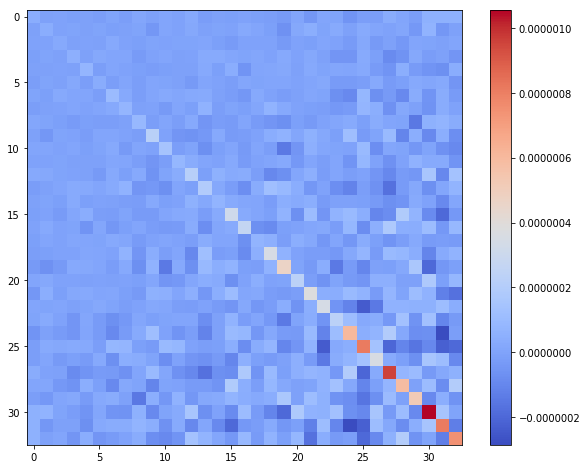

In [768]:
plt.figure(figsize = (10,8))
plt.imshow(M_jx, cmap = 'coolwarm')
plt.colorbar()

In [704]:
np.mean(cl_f_all_ali, axis = 0).shape

(3, 10, 2, 2)

In [708]:
nl_mean_ali.shape

(3, 10, 2, 2)

In [713]:
nl_mean_ali[0,:,0,0]

array([-0.00041219,  0.00020354,  0.00063605,  0.00124348,  0.00201675,
        0.00300886,  0.00415157,  0.00551854,  0.00706905,  0.00932862])

In [714]:
nl_mean_ali[0,:,1,1]

array([-0.00042062,  0.00020304,  0.00063654,  0.00123639,  0.00202761,
        0.00300844,  0.0041678 ,  0.00552653,  0.00707581,  0.00931551])

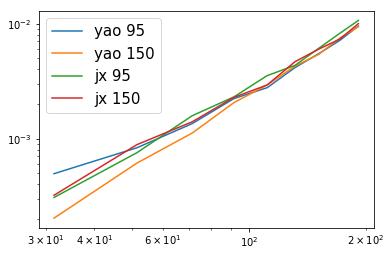

In [730]:
plt.loglog(leff[1:], nl_all_ali[0][2,1:,0,0], label = 'yao 95')
plt.loglog(leff[1:], nl_all_ali[2,0,1:,1,1], label = 'yao 150')
plt.loglog(leff[1:], Njx[0][0:9, 0,0], label = 'jx 95')
plt.loglog(leff[1:], Njx[0][0:9, 1,1], label = 'jx 150')
plt.legend(fontsize =15)

In [729]:
 np.mean(nl_all_ali, axis = 0).shape

(3, 10, 2, 2)

Text(0.5, 1.0, 'Mean Nl')

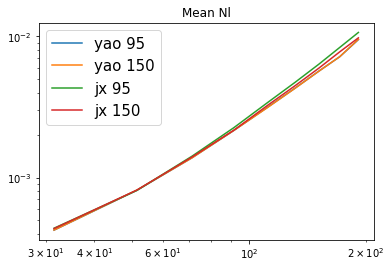

In [735]:
plt.loglog(leff[1:], np.mean(nl_all_ali, axis = 0)[2,1:,0,0], label = 'yao 95')
plt.loglog(leff[1:], np.mean(nl_all_ali, axis = 0)[2,1:,1,1], label = 'yao 150')
plt.loglog(leff[1:], np.mean(Njx, axis = 0)[0:9, 0,0], label = 'jx 95')
plt.loglog(leff[1:], np.mean(Njx, axis = 0)[0:9, 1,1], label = 'jx 150')
plt.legend(fontsize =15)
plt.title('Mean Nl')

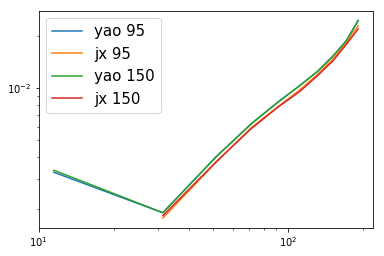

In [715]:
# plt.loglog(leff, cl_f_all_ali[2,2,:,0,0], label = 'yao')
# plt.loglog(leff, cl_f_all_ali[2,2,:,1,1], label = 'yao')


plt.loglog(leff, np.mean(cl_f_all_ali, axis = 0)[2,:,0,0], label = 'yao 95')
plt.loglog(leff[1:], np.mean(Xjx[1:], axis = 0)[0:9,0,0], label = 'jx 95')

plt.loglog(leff, np.mean(cl_f_all_ali, axis = 0)[2,:,1,1], label = 'yao 150')
plt.loglog(leff[1:], np.mean(Xjx[1:], axis = 0)[0:9,1,1], label = 'jx 150')

# nr = 2
# plt.loglog(leff[1:], Xjx[nr,0:9,0,0], label = 'jx')
# plt.loglog(leff[1:], Xjx[nr,0:9,1,1], label = 'jx')

plt.legend(fontsize = 15)

In [755]:
marry_ali[lbin*nf_ind*2:].shape

(30, 500)

In [756]:
M_20 = np.cov(marry_ali[lbin*nf_ind*2:][:, 0:20])

In [757]:
LA.norm(M_20)

6.651703690813109e-06

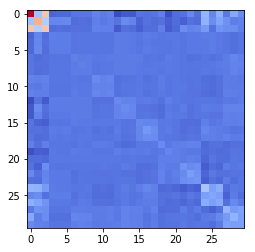

In [758]:
plt.imshow(M_20, cmap = 'coolwarm')

In [532]:
jxm = np.load('/fnx/jianyao/Likelihood_data/Bandpowers/0710_2fre_Ali_real_fore_and_noise/M_b.npy')

In [615]:
LA.norm(jxm)

2.8169923393865974e-07

In [616]:
(cov_mat_BB_ali)

5.196840571528225e-07

In [583]:
np.diag(cov_mat_BB_ali)

array([2.63511927e-07, 2.90616916e-07, 1.71407936e-07, 6.62558997e-08,
       6.36928324e-08, 4.74734257e-08])

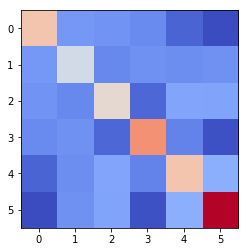

In [540]:
plt.imshow(jxm, cmap = 'coolwarm')

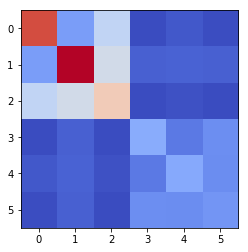

In [538]:
plt.imshow(cov_mat_BB_ali, cmap='coolwarm')
# plt.colorbar()

In [846]:
A_d_RJ = np.load('/fnx/jianyao/Likelihood_data/Bandpowers/0629_2fre_Ali/dust_template_353_BB_RJ.npy')
dust_dl_RJ = np.load('/fnx/jianyao/Likelihood_data/Bandpowers/0629_2fre_Ali/dust_BB_cross_fre_1p56_from_RJ.npy')


A_s_RJ = np.load('/fnx/jianyao/Likelihood_data/Bandpowers/0629_2fre_Ali/sync_template_30_BB_RJ.npy')
sync_dl_RJ = np.load('/fnx/jianyao/Likelihood_data/Bandpowers/0629_2fre_Ali/sync_BB_cross_fre_n3p0_from_RJ.npy')

In [479]:
fl_pysm = np.load('/fnx/jianyao/Likelihood_data/Bandpowers/0710_2fre_Ali_real_fore_and_noise/fl_pysm.npy')

In [59]:
testL_sub(cl_hat_0_ali[2], fl_hat, cl_f_ali[2], cl_th_BB_ali,Nf,cov_mat_BB_ali,sbin = 1)

(-9850.07503983932-8.526512829121202e-14j)

#### likelihood for r

In [845]:
cl_hat_all_ali.shape

(500, 3, 10, 2, 2)

In [937]:
simple_likelihood(cl_hat_fore_ali, C_l, Nf = Nf, M = cov_mat_BB_ali, sbin = 1)

-5039.231697009017

In [934]:
npara = 4; Nsim = 11;

def prior(cube):
    
    r = cube[0]*0.3
    beta_s = cube[1]*2 - 4## from -4 to -2
    beta_d = cube[2]*0.4 + 1.4 ## from 1.4 to 1.8
    epsilon = cube[3];
    
    return [r, beta_s, beta_d, epsilon]

Mean = np.zeros((Nsim,npara)); Samples = np.zeros((Nsim, npara)); Weights = np.zeros(Nsim); Results = []

for n in range(Nsim):
    
    cl_hat_fore_ali = cl_hat_all_ali[n][2] #+ sync_dl_RJ + dust_dl_RJ 
      
    def log_likelihood(cube, likelihood = 1):
        r_i = cube[0];
        beta_s = cube[1];
        beta_d = cube[2];
        epsilon = cube[3];

        bb_tensor = bb_05[0:nmtlmax+1]*r_i/0.05 

        bb_camb = bb_tensor + lensingB[2][0:nmtlmax+1] ## tensor BB + lensing BB 

        cl_th_i = b.bin_cell(bb_camb[0:nmtlmax+1])  ## theoretical bandpower 
        cl_th_test = np.ones((lbin, Nf, Nf));  ## BB cross power spectra
        for ell in range(lbin):
            cl_th_test[ell] *= cl_th_i[ell]

        fl_hat = sync_ps(A_s_RJ, beta_s, lbin) + dust_ps(A_d_RJ, beta_d, lbin) + corre_fore_simple(epsilon, A_d_RJ, A_s_RJ, beta_s, beta_d, lbin)

        ## gaussian
        if likelihood == 1:

            C_l = cl_th_test + nl_mean_ali[2] + fl_hat;
            logL = simple_likelihood(cl_hat_fore_ali, C_l, Nf = Nf, M = cov_mat_BB_ali, sbin = 1)

        ## subtract fl from Cl_hat
        elif likelihood == 2:

            # add Noise bias N_l to expectation values.########################## Noise level
            C_l = cl_th_test + nl_mean_ali[2] 

            logL = testL_sub((cl_hat_fore_ali), fl_hat , cl_f_ali[2], C_l, Nf = Nf, M = cov_mat_BB_ali, sbin = 1)

        ## add fl to Cl_fiducial
        else:
            C_l = cl_th_test + nl_mean_ali[2] + sync_ps(A_s_RJ, beta_s, 10) + dust_ps(A_d_RJ, beta_d, 10);

            logL = testL((cl_hat_fore_ali) , cl_f_ali[2], C_l, Nf = Nf, M = cov_mat_BB_ali, sbin = 1);     

        return np.real(logL)
    
    with Pool(cpu_count()-1) as executor:
        
        sampler = dynesty.NestedSampler(log_likelihood, prior, npara, nlive=400, pool=executor, queue_size=cpu_count(), bootstrap = 0)
        sampler.run_nested(dlogz = 0.1)
        results = sampler.results
    
    Results.append(results)
    
#     if n == 0 : 
#         samples, weights = results.samples, np.exp(results.logwt - results.logz[-1])
    
#     else: 
#         _samples, _weights = results.samples, np.exp(results.logwt - results.logz[-1])
#         samples = np.r_[samples, _samples];
#         weights = np.r_[weights, _weights];

7688it [00:17, 433.08it/s, +400 | bound: 31 | nc: 1 | ncall: 32006 | eff(%): 25.270 | loglstar:   -inf < -180.800 <    inf | logz: -197.666 +/-  0.276 | dlogz:  0.000 >  0.100]
9098it [00:21, 424.90it/s, +400 | bound: 46 | nc: 1 | ncall: 41756 | eff(%): 22.746 | loglstar:   -inf < -496.046 <    inf | logz: -516.444 +/-  0.304 | dlogz:  0.000 >  0.100]
7821it [00:14, 547.90it/s, +400 | bound: 32 | nc: 1 | ncall: 32794 | eff(%): 25.069 | loglstar:   -inf < -164.263 <    inf | logz: -181.461 +/-  0.280 | dlogz:  0.000 >  0.100]
7616it [00:16, 448.74it/s, +400 | bound: 34 | nc: 1 | ncall: 34596 | eff(%): 23.170 | loglstar:   -inf < -814.265 <    inf | logz: -830.951 +/-  0.275 | dlogz:  0.000 >  0.100]
7655it [00:14, 530.39it/s, +400 | bound: 32 | nc: 1 | ncall: 32969 | eff(%): 24.432 | loglstar:   -inf < -300.877 <    inf | logz: -317.662 +/-  0.275 | dlogz:  0.000 >  0.100]
7490it [00:14, 524.84it/s, +400 | bound: 31 | nc: 1 | ncall: 32745 | eff(%): 24.095 | loglstar:   -inf < -871.467 <

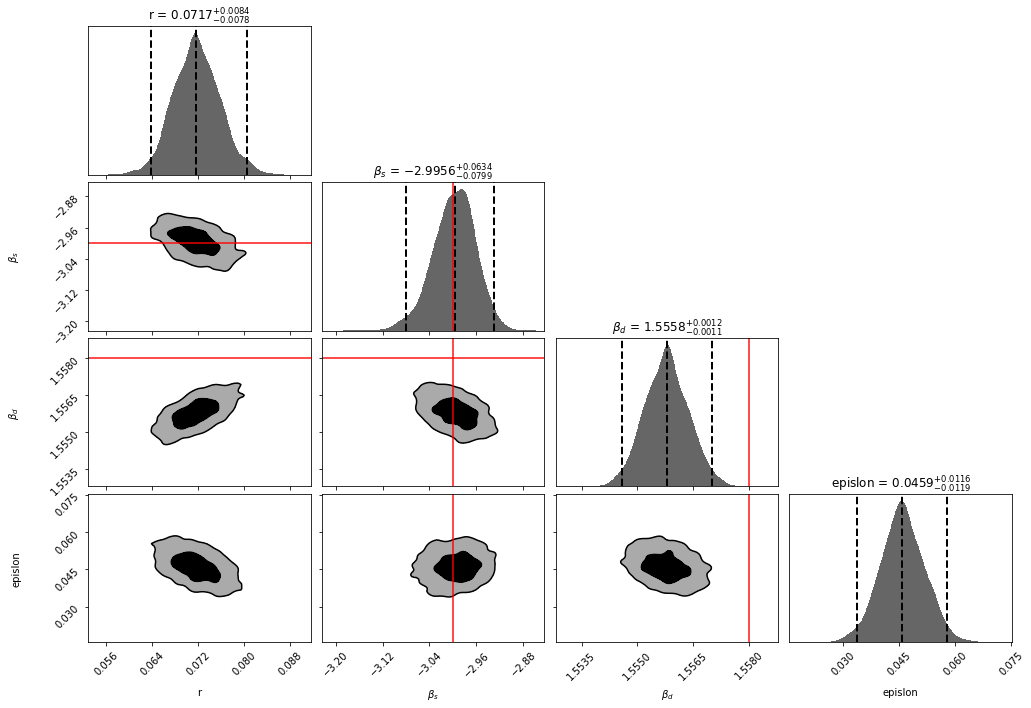

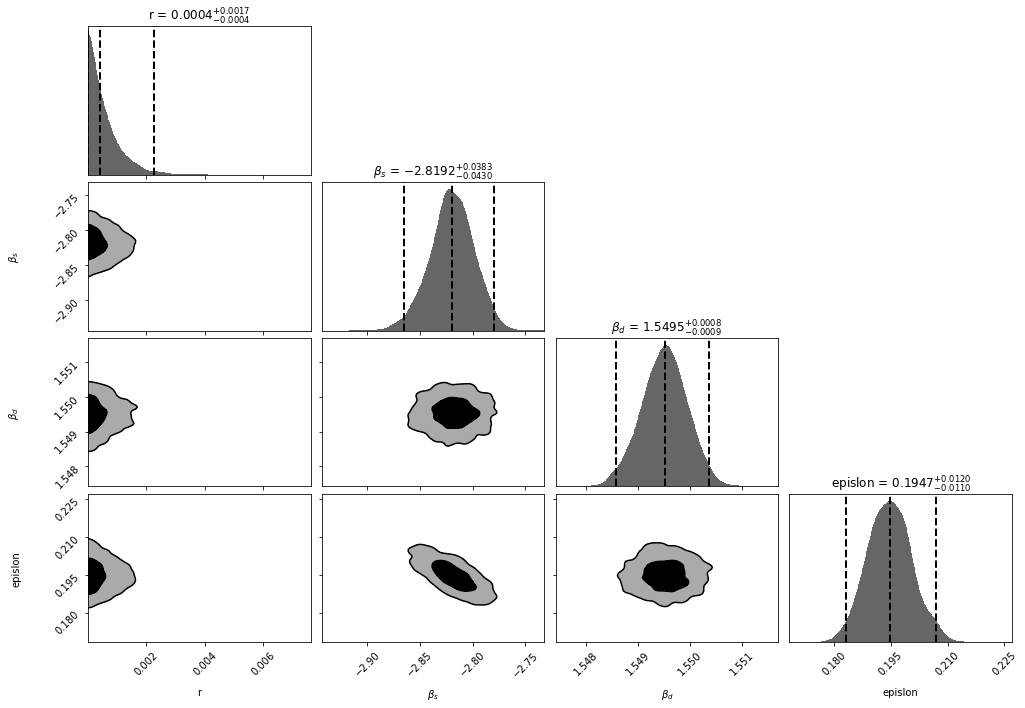

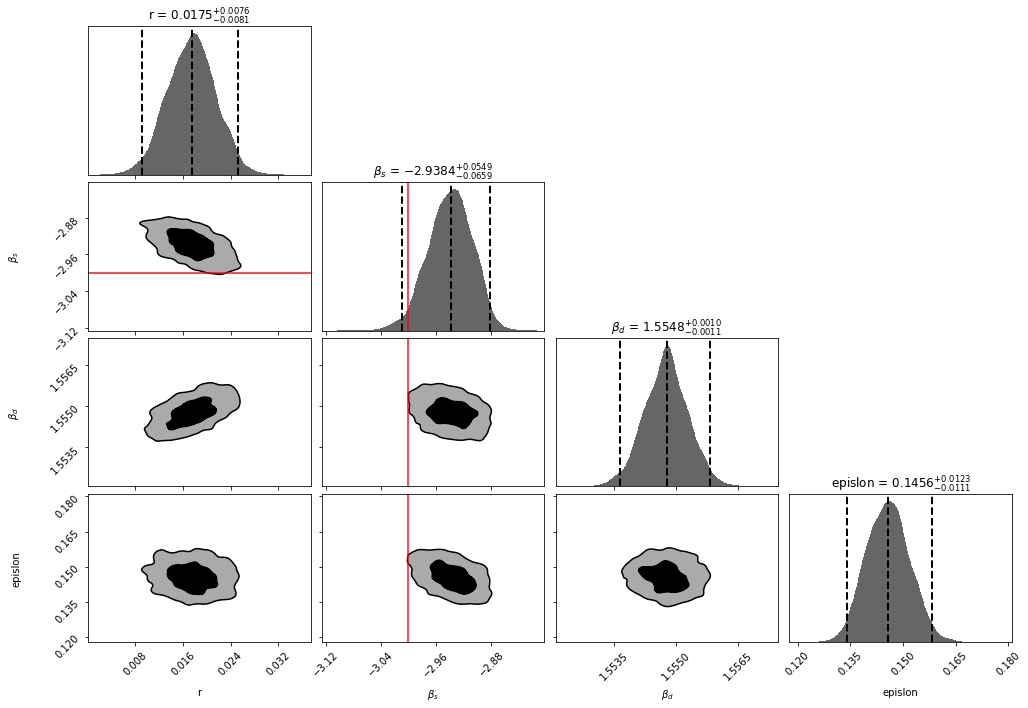

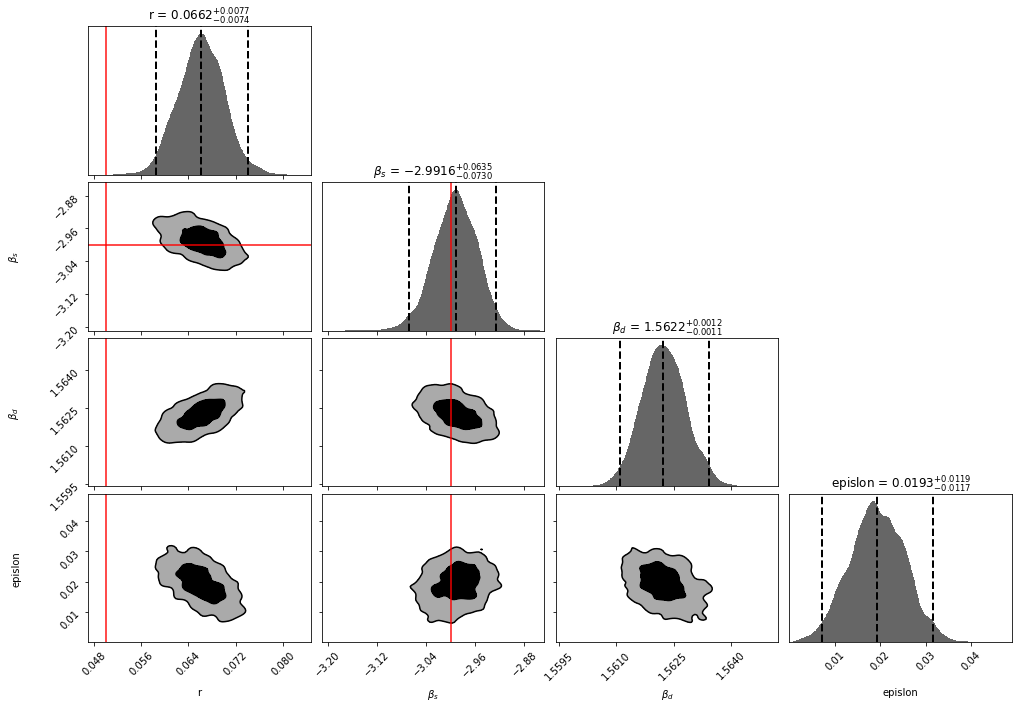

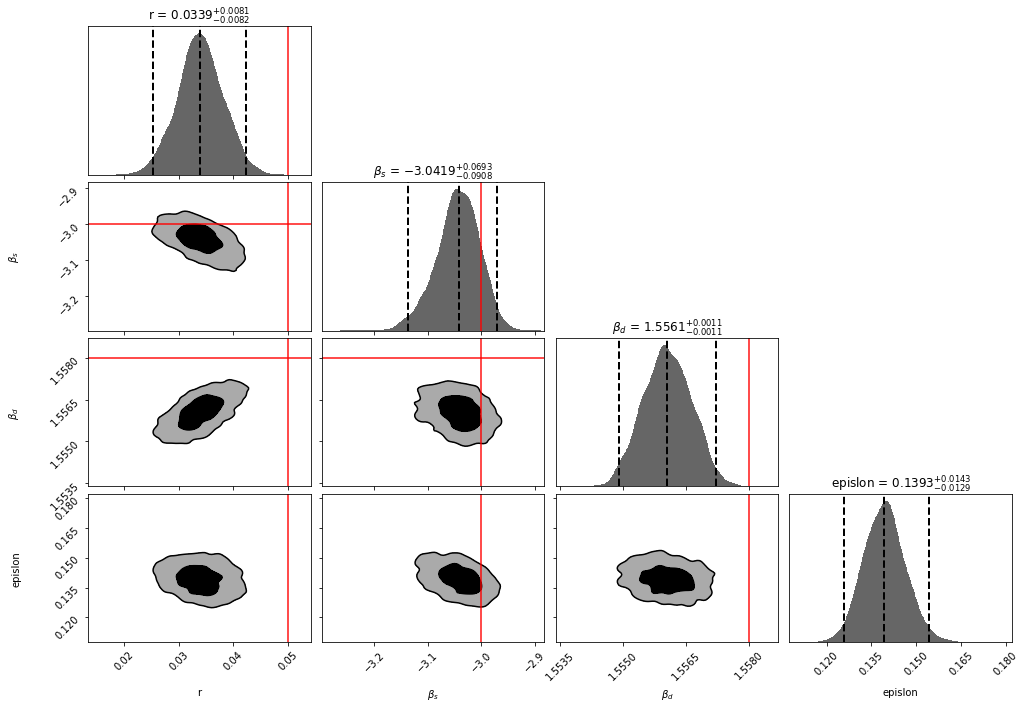

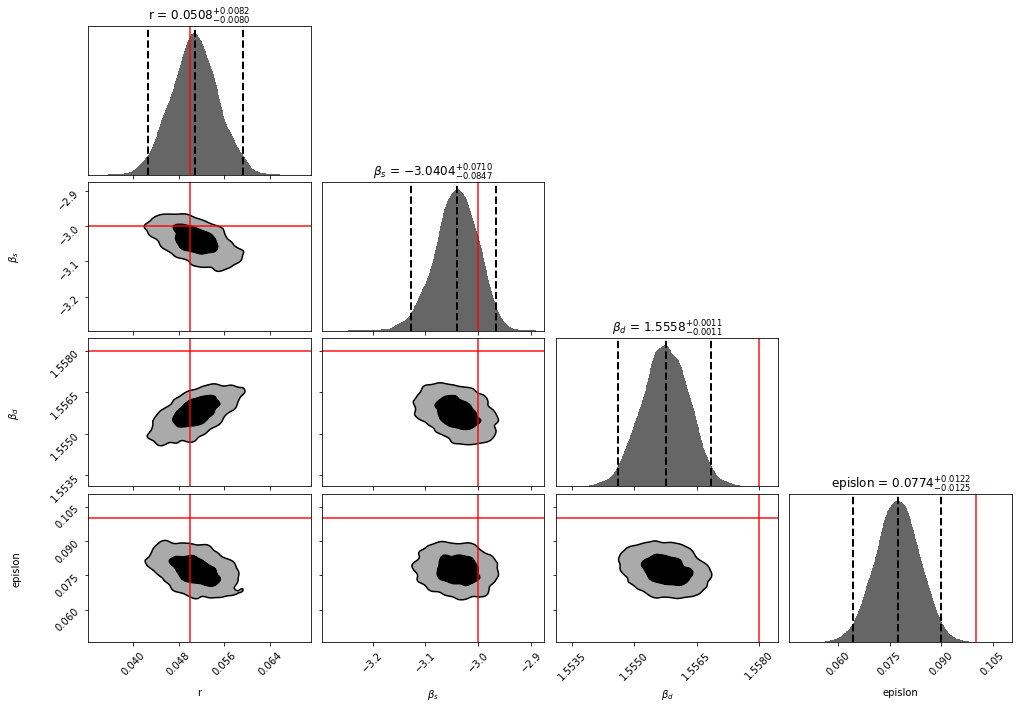

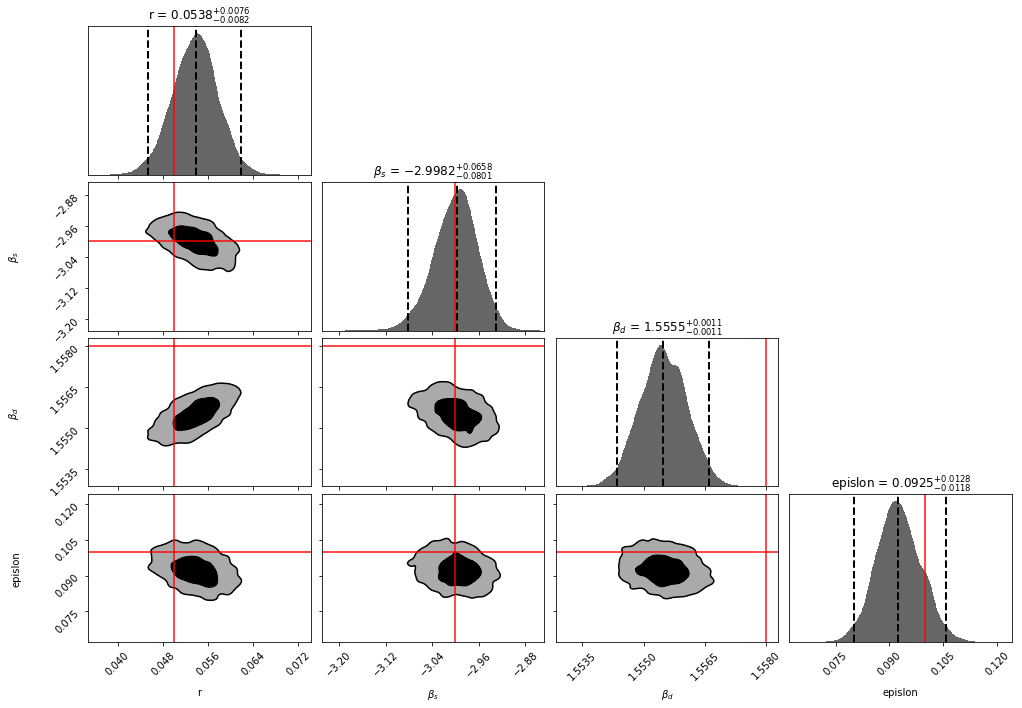

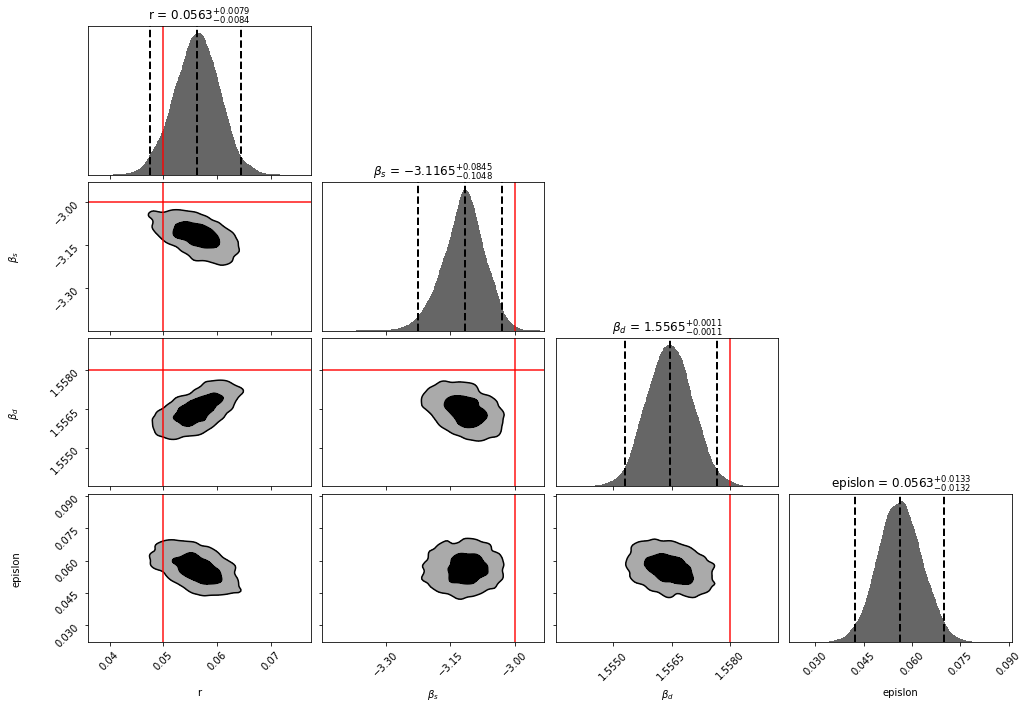

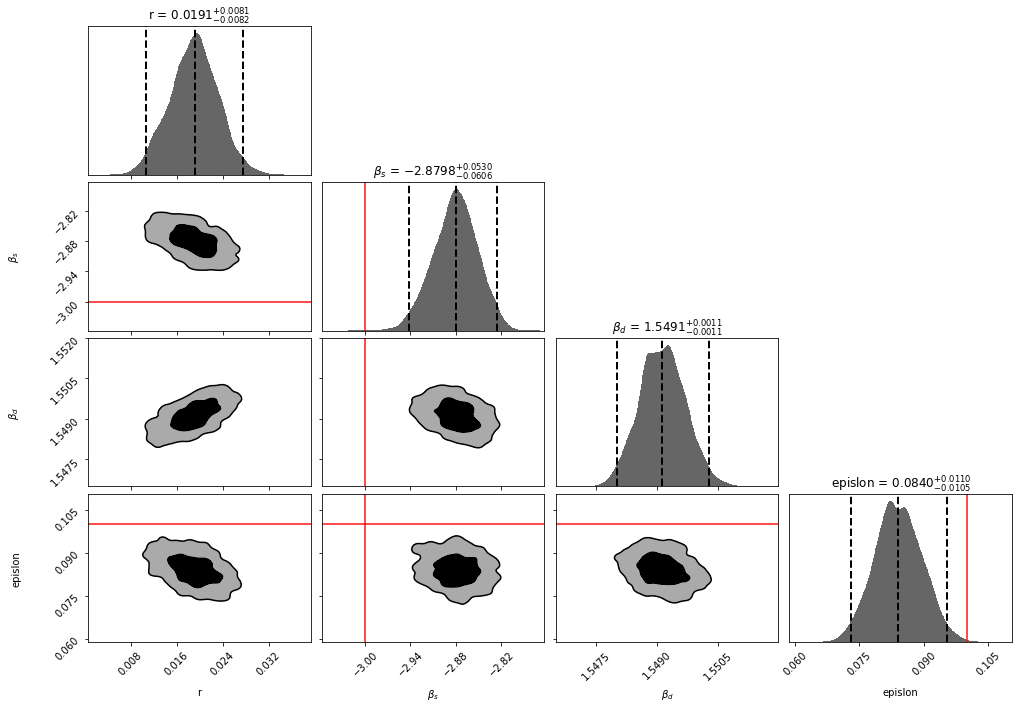

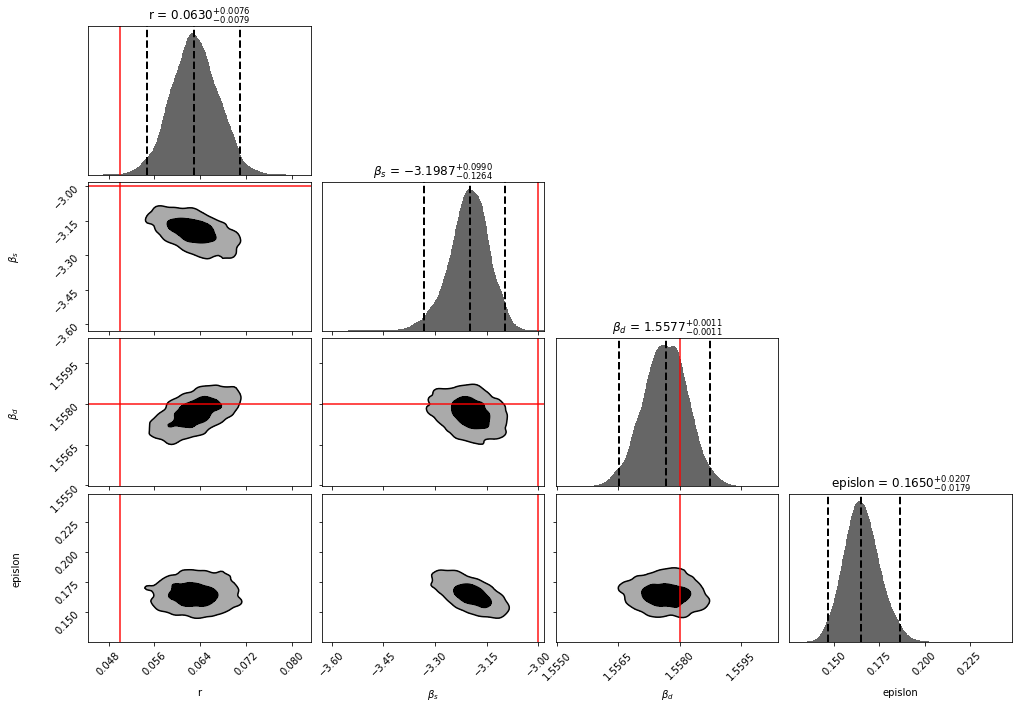

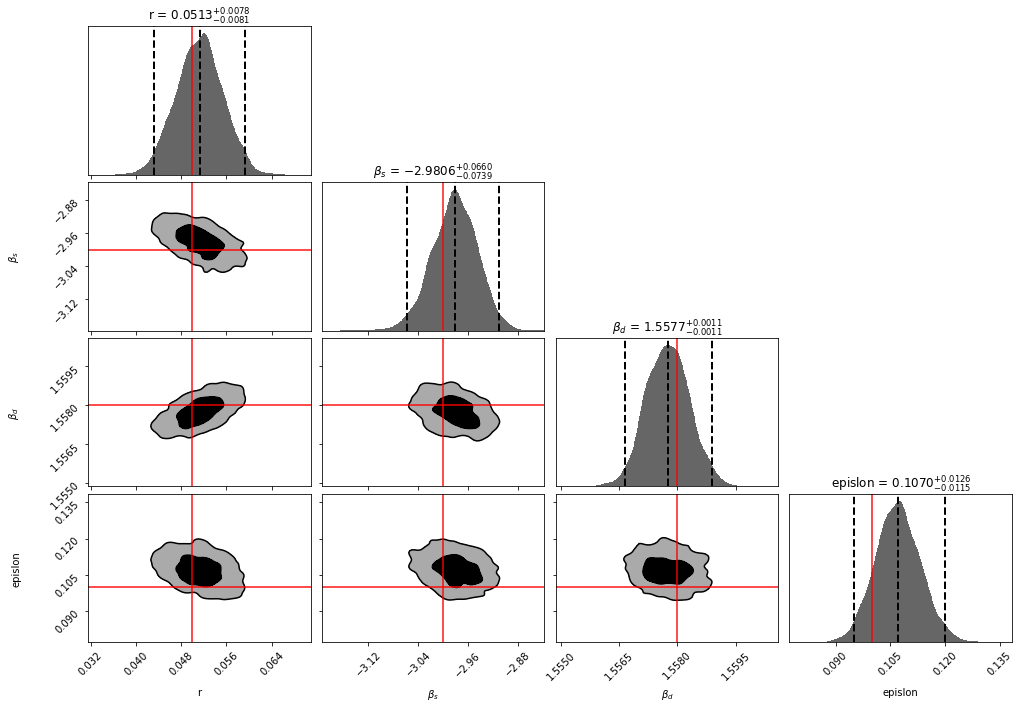

In [936]:
for n in range(Nsim):
    
    labels = ['r', r'$\beta_s$',r'$\beta_d$', r'epislon']; 
    fig, axes = plt.subplots(npara, npara, figsize=(15, 10))
    axes = axes.reshape((npara, npara)) 

    fig, ax = dyplot.cornerplot(Results[n], truths=truth, fig = (fig, axes), title_fmt='.4f', show_titles=True,
                     labels = labels,quantiles = sig2, quantiles_2d = [0.4,0.85]) #0.1, 0.4, 0.65, 0.85

#### likelihood for foreground only

In [658]:
slist = np.linspace(-4, -2, 100); lall_s = np.ones(len(slist))
for i in range(len(dlist)):
    s_i = slist[i];
    lall_s[i] = simple_likelihood(fl_pysm[2], sync_ps(A_s_RJ, s_i, 10) + dust_ps(A_d_RJ, 1.558, 10) , Nf = Nf, M = cov_mat_BB_ali, sbin = 0)

In [659]:
dlist = np.linspace(1.4, 1.8, 100); lall_d = np.ones(len(dlist))
for i in range(len(dlist)):
    d_i = dlist[i];
    lall_d[i] = simple_likelihood(fl_pysm[2], sync_ps(A_s_RJ, -3.0, lbin) + dust_ps(A_d_RJ, d_i, lbin) , Nf = Nf, M = cov_mat_BB_ali, sbin = 0)

In [670]:
cov_mat_BB_ali[0]

array([ 3.26996756e-06,  5.52457336e-07,  1.34393914e-06, -1.00714326e-07,
       -2.97963392e-08, -6.08825758e-08,  5.17528450e-09, -1.23995338e-08,
       -4.16131054e-09,  1.49728108e-08,  3.21245181e-08,  2.51867168e-08,
       -1.08539303e-08, -7.46696058e-09, -2.47745444e-09, -5.81866302e-08,
        3.13137962e-09, -5.18413668e-08,  1.33052582e-08, -3.98988629e-08,
       -8.98523995e-09,  1.27626787e-08,  1.12121257e-07,  2.80735822e-08,
        1.22903658e-08,  2.80762540e-08,  4.40246369e-08,  7.59575511e-08,
        5.66392992e-08,  4.72925245e-08])

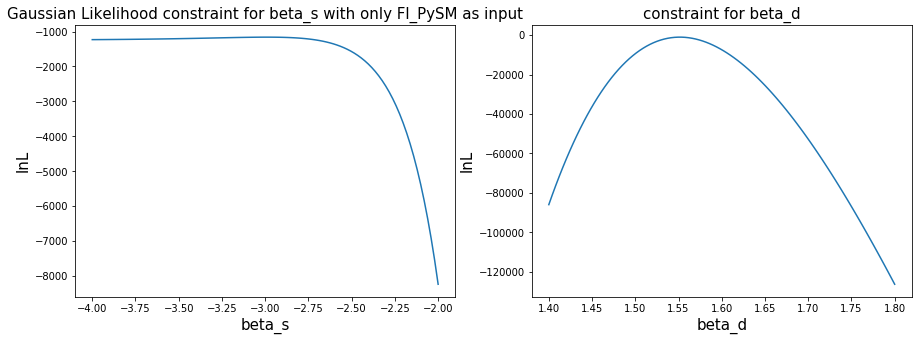

In [671]:
fig, ax = plt.subplots(1,2, figsize = (15,5 ))

ax[0].plot(slist, (lall_s))
ax[0].set_xlabel('beta_s', fontsize = 15);
ax[0].set_ylabel('lnL',fontsize = 15);
ax[0].set_title("Gaussian Likelihood constraint for beta_s with only Fl_PySM as input",fontsize = 15)

plt.plot(dlist, lall_d)
plt.xlabel('beta_d', fontsize = 15);
plt.ylabel('lnL',fontsize = 15);
plt.title("constraint for beta_d",fontsize = 15)

plt.savefig('./fig_results/0803_Gaussian_Likelihood_beta_s_beta_d.pdf', format = 'pdf')

In [285]:
# simple_likelihood(cl_hat_0_ali[2], cl_th_BB_ali, 2, cov_mat_BB_ali, sbin=1)

rlist = np.arange(0, 0.1, 0.001)
logLike = np.zeros(len(rlist))

# loop over r values
for i in range(len(rlist)):

    r_i  =  rlist[i]
    bb_tensor = bb_05[0:nmtlmax+1]*r_i/0.05 

    bb_camb = bb_tensor + lensingB[2][0:nmtlmax+1] ## tensor BB + lensing BB 

    cl_th_i = b.bin_cell(bb_camb[0:nmtlmax+1])  ## theoretical bandpower 
    cl_th_test = np.ones((lbin, Nf, Nf));  ## BB cross power spectra
    for ell in range(lbin):
        cl_th_test[ell] *= cl_th_i[ell]

    fl_hat = sync_ps(A_s_RJ, -3.0, 10) + dust_ps(A_d_RJ, 1.558, 10)  

    C_l = cl_th_test + nl_mean_ali[2] + fl_hat;

    logL = simple_likelihood(cl_hat_all_ali[10][2] + sync_dl_RJ + dust_dl_RJ, C_l, Nf = Nf, M = cov_mat_BB_ali, sbin = 1)
    logLike[i] = np.real(logL)

r_max = rlist[np.argsort(logLike)[-1]]

plt.plot(rlist, (logLike))
plt.axvline(0.05, c='r', ls='--')

In [ ]:
npara = 2; Nsim = 1;

def prior(cube):
    
    beta_s = cube[0]*2 - 4## from -4 to -2
    beta_d = cube[1]*0.4 + 1.4 ## from 1.4 to 1.8
    
    return [beta_s, beta_d]#[bp0, bp1, bp2, bp3, bp4, bp5, bp6, bp7, bp8, bp9,  beta_s, beta_d]

Mean = np.zeros((Nsim,npara)); Samples = np.zeros((Nsim, npara)); Weights = np.zeros(Nsim);

for n in range(Nsim):
    
#     cmb_cross_cl = np.zeros_like(sync_dl_RJ)

#     for i in range(lbin):
#         cmb_cross_cl[i] = sync_dl_RJ[i] + dust_dl_RJ[i] + cmb_cl[n][i] ### signal only, without noise.
    
    cl_hat_fore_ali = sync_dl_RJ + dust_dl_RJ #cl_hat_all_ali[n][2] #+  #cmb_cross_cl # ## foreground from model or PySM;
      
    def log_likelihood(cube, likelihood = 1):
        beta_s = cube[0]
        beta_d = cube[1]
        
        fl_hat = sync_ps(A_s_RJ, beta_s, lbin) + dust_ps(A_d_RJ, beta_d, lbin)  

        ## gaussian
        if likelihood == 1:

            C_l = fl_hat;
            logL = simple_likelihood(cl_hat_fore_ali, C_l, Nf = Nf, M = cov_mat_BB_ali, sbin = 0)
    
    with Pool(cpu_count()-1) as executor:
        
        sampler = dynesty.NestedSampler(log_likelihood, prior, npara, nlive=400, pool=executor, queue_size=cpu_count(), bootstrap = 0)
        sampler.run_nested(dlogz = 0.1)
        results = sampler.results

    if n == 0 : 
        samples, weights = results.samples, np.exp(results.logwt - results.logz[-1])
    
    else: 
        _samples, _weights = results.samples, np.exp(results.logwt - results.logz[-1])
        samples = np.r_[samples, _samples];
        weights = np.r_[weights, _weights];

#### likelihood for bandpowers

Treat every bandpower at each ell as a free parameter

In [337]:
cmb_cl = np.load('/fnx/jianyao/Likelihood_data/Bandpowers/0629_2fre_Ali/CMB_only_dl_ali.npy')

In [545]:
npara = 4; Nsim = 1;

def prior(cube):
    
    bp0 = cube[0]; bp1 = cube[1]; #bp2 = cube[2];bp3 = cube[3]; bp4 = cube[5]; bp5 = cube[5]; bp6 = cube[6]; bp7 = cube[7]; bp8 = cube[8]; bp9 = cube[9]
    beta_s = cube[2]*2 - 4## from -4 to -2
    beta_d = cube[3]*0.4 + 1.4 ## from 1.4 to 1.8
    
    return [bp0, bp1, beta_s, beta_d]#[bp0, bp1, bp2, bp3, bp4, bp5, bp6, bp7, bp8, bp9,  beta_s, beta_d]

Mean = np.zeros((Nsim,npara)); Samples = np.zeros((Nsim, npara)); Weights = np.zeros(Nsim);

for n in range(Nsim):
    
#     cmb_cross_cl = np.zeros_like(sync_dl_RJ)

#     for i in range(lbin):
#         cmb_cross_cl[i] = sync_dl_RJ[i] + dust_dl_RJ[i] + cmb_cl[n][i] ### signal only, without noise.
    
    cl_hat_fore_ali = cl_hat_all_ali[n][2] #+ sync_dl_RJ + dust_dl_RJ #cmb_cross_cl # ## foreground from model or PySM;
      
    def log_likelihood(cube, likelihood = 1):
        bp0 = cube[0]; bp1 = cube[1];# bp2 = cube[2];bp3 = cube[3]; bp4 = cube[5]; bp5 = cube[5]; bp6 = cube[6]; bp7 = cube[7]; bp8 = cube[8]; bp9 = cube[9]
        beta_s = cube[2]
        beta_d = cube[3]
        
        bps = [bp0, bp1]#, bp2, bp3, bp4, bp5, bp6, bp7, bp8, bp9]
       
        cl_th_test = np.ones((lbin, Nf, Nf));  ## BB cross power spectra
        for ell in range(lbin):
            cl_th_test[ell] *= bps[ell]

        fl_hat = sync_ps(A_s_RJ, beta_s, lbin) + dust_ps(A_d_RJ, beta_d, lbin)  

        ## gaussian
        if likelihood == 1:

            C_l = cl_th_test + fl_hat + nl_mean_ali[2];
            logL = simple_likelihood(cl_hat_fore_ali, C_l, Nf = Nf, M = cov_mat_BB_ali, sbin = 0)

        ## subtract fl from Cl_hat
        elif likelihood == 2:

            # add Noise bias N_l to expectation values.########################## Noise level
            C_l = cl_th_test + nl_mean_ali[2]; 

            logL = testL_sub((cl_hat_fore_ali), fl_hat , cl_f_ali[2], C_l, Nf = Nf, M = cov_mat_BB_ali, sbin = 1)

        ## add fl to Cl_fiducial
        else:
            C_l = cl_th_test + nl_mean_ali[2] + sync_ps(A_s_RJ, beta_s, lbin) + dust_ps(A_d_RJ, beta_d, lbin);

            logL = testL((cl_hat_fore_ali) , cl_f_ali[2], C_l, Nf = Nf, M = cov_mat_BB_ali, sbin = 1);     

        return np.real(logL)
    
    with Pool(cpu_count()-1) as executor:
        
        sampler = dynesty.NestedSampler(log_likelihood, prior, npara, nlive=400, pool=executor, queue_size=cpu_count(), bootstrap = 0)
        sampler.run_nested(dlogz = 0.1)
        results = sampler.results

    if n == 0 : 
        samples, weights = results.samples, np.exp(results.logwt - results.logz[-1])
    
    else: 
        _samples, _weights = results.samples, np.exp(results.logwt - results.logz[-1])
        samples = np.r_[samples, _samples];
        weights = np.r_[weights, _weights];

9831it [00:12, 779.90it/s, +400 | bound: 45 | nc: 1 | ncall: 40760 | eff(%): 25.101 | loglstar:   -inf < -46.033 <    inf | logz: -68.255 +/-  0.321 | dlogz:  0.000 >  0.100]     


In [376]:
sample_i, weight_i = results.samples, np.exp(results.logwt - results.logz[-1])

best_fit = np.ones(npara);
for i in range(npara):
    best_fit[i] = dynesty.utils.quantile(sample_i[:,i], [0.5], weight_i)[0]

In [316]:
print("Foreground from model")
print("beta_s", best_fit[10])
print("beta_d", best_fit[11])

Foreground from model
beta_s -3.022735390720868
beta_d 1.5599700978447202


In [377]:
print("Foreground from PySM")
print("beta_s", best_fit[10])
print("beta_d", best_fit[11])

Foreground from PySM
beta_s -3.0440597595173124
beta_d 1.5602761367199591


In [397]:
error = np.sqrt(np.diag(cov_mat_BB_ali)[::3])

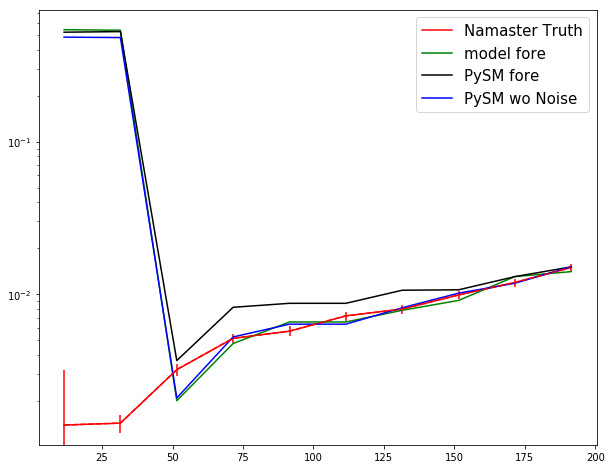

In [458]:
plt.figure(figsize = (10,8))
plt.plot(leff, cmb_cl[0], 'r-', label = 'Namaster Truth')
plt.errorbar(leff, cmb_cl[0], error, ls = '--', c = 'red')

plt.plot(leff, cl_model_fore, 'g-',label = 'model fore')
plt.plot(leff, cl_Pysm_fore,'k-', label = 'PySM fore')
plt.plot(leff, cl_Pysm_woNoise, 'b-', label = 'PySM wo Noise')
plt.yscale('log')
# plt.loglog(fl_hat[0:,0,0], label = 'Fore 95GHz')
# plt.loglog(fl_hat[0:,1,1], label = 'Fore 150GHz')

plt.legend(fontsize = 15)

###  manual likelihood test

In [2645]:
npt = 50;
x1 = np.linspace(0,0.1, npt); x2 = np.linspace(-2.5, -3, npt); x3 = np.linspace(1.5,2, npt);

X,Y = np.meshgrid(x1,x2)
Z = np.zeros_like(X)

for i in range(npt):
    for j in range(npt):
        
        cube = [x1[i], x2[j], 1.56]
        Z[i,j] = log_likelihood(cube, subtract= True)

/home/jianyao/Likelihood/utils.py:217: RuntimeWarning: invalid value encountered in log
  gd = np.sign(np.diag(d) - 1) * np.sqrt(2 * (np.diag(d) - np.log(np.diag(d)) - 1))


In [2661]:
Z = np.zeros_like(x1)
for i in range(npt):
    
    cube = [0.0476, -2.97, x3[i]]
    Z[i] = log_likelihood(cube, subtract= False)

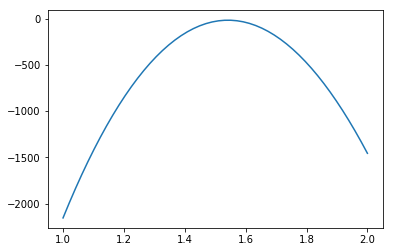

In [2662]:
plt.plot(x3, Z)

In [2688]:
npt = 50;
x1 = np.linspace(0,1, npt); x2 = np.linspace(-2.5, -3, npt); x3 = np.linspace(1,2, npt);

X,Y = np.meshgrid(x1,x3)
Z = np.zeros_like(X)

for i in range(npt):
    for j in range(npt):
        
        cube = [x1[i], -2.97, x3[j]]
        Z[i,j] = log_likelihood(cube, subtract= False)

In [2677]:
import seaborn

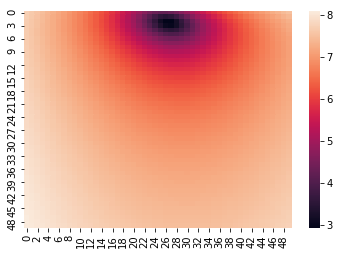

In [2693]:
seaborn.heatmap(np.log(-Z))

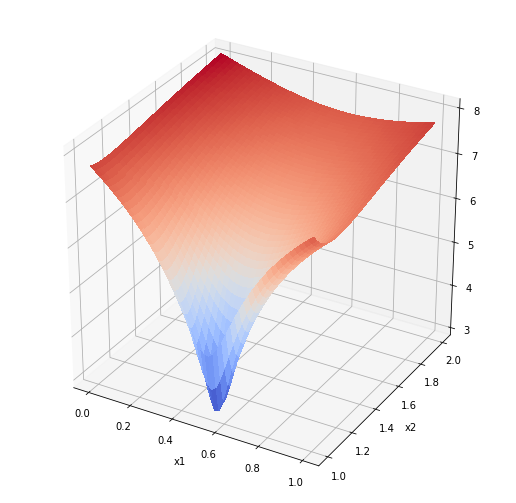

In [2692]:
fig = plt.figure(figsize=(9,9))
ax = fig.gca(projection='3d')
ax.set_xlabel('x1')
ax.set_ylabel('x2')

ax.plot_surface(X, Y, np.log(-Z), cmap='coolwarm', linewidth=0, antialiased=False)

### Foreground test

In [2231]:
# for beta_s in np.arange(-4, -2, 0.01):
    
#     print(testL(abs(cl_hat_fore_ali - sync_ps(A_s_RJ, beta_s, 10) - dust_ps(A_d_RJ, 1.59, 10)), cl_f_ali[2], C_l, Nf = Nf, M = cov_mat_BB_ali, sbin = 0))

In [2232]:
# for beta_s in np.arange(-4, -2, 0.1):
    
#     print(LA.eigvals(abs(cl_hat_fore_ali - dust_ps(A_d_RJ, 1.59, 10) - sync_ps(A_s, beta_s, 10))[1]))

In [2233]:
# for beta_s in np.arange(-4, -2, 0.1):
    
#     print(LA.eigvals((cl_hat_fore_ali - dust_ps(A_d_RJ, 1.59, 10) - sync_ps(A_s, beta_s, 10))[1]))

In [2235]:
# for beta in np.arange(1,2, 0.1):
    
#     print(LA.eigvals(abs(cl_hat_fore_ali - sync_ps(A_s_RJ, -3.3, 10) - dust_ps(A_d_RJ, beta, 10))))

In [2236]:
# # for beta in np.arange(1.58,1.60, 0.001):
# for beta in np.arange(1,2, 0.01):
    
#     print(testL(cl_hat_fore_ali - sync_ps(A_s_RJ, -3.3, 10) - dust_ps(A_d_RJ, beta, 10), cl_f_ali[2], C_l, Nf = Nf, M = cov_mat_BB_ali, sbin = 1))

In [591]:
leff

array([ 41.5, 121.5])

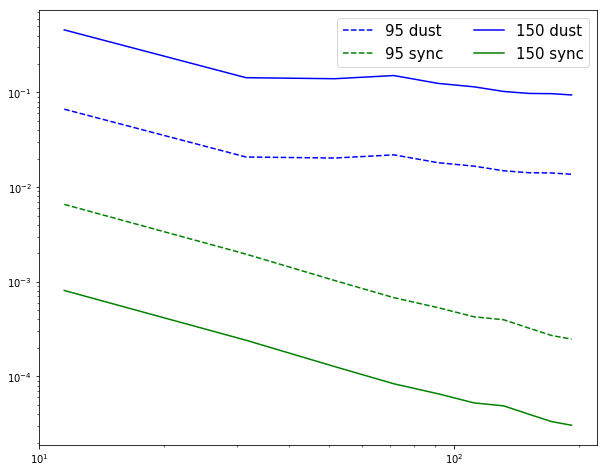

In [595]:
plt.figure(figsize=(10,8))
plt.loglog(leff, dust_dl_RJ[:,0,0], 'b--', label = '95 dust')
plt.loglog(leff, sync_dl_RJ[:,0,0], 'g--', label = '95 sync')
plt.loglog(leff, dust_dl_RJ[:,1,1], 'b-', label = '150 dust')
plt.loglog(leff, sync_dl_RJ[:,1,1], 'g-',label = '150 sync')

# plt.loglog(leff, fl_pysm[2][:,0,0], label = 'PySM 95')  
# plt.loglog(leff, fl_pysm[2][:,1,1], label = 'PySM 150')                                             


plt.legend(fontsize = 15, ncol = 2)
# plt.savefig('./fig_results/foregrounds_95_150.pdf', format = 'pdf')

In [481]:
sync_dl_RJ.shape

(2, 2, 2)

### dynesty

In [882]:
truth = np.array([0.05, -3.0, 1.558, 0.1])

# truth = np.array([0.00260132, 0.00790004, -3.0, 1.56])

# truth = np.array([-3.0, 1.558])
npara = len(truth)

In [39]:
sig1 = [0.16, 0.5, 0.84]; sig2 = [0.021, 0.5, 0.979];

##### without epsilon

In [897]:
np.std(resamples[:,0])

0.02146290037114369

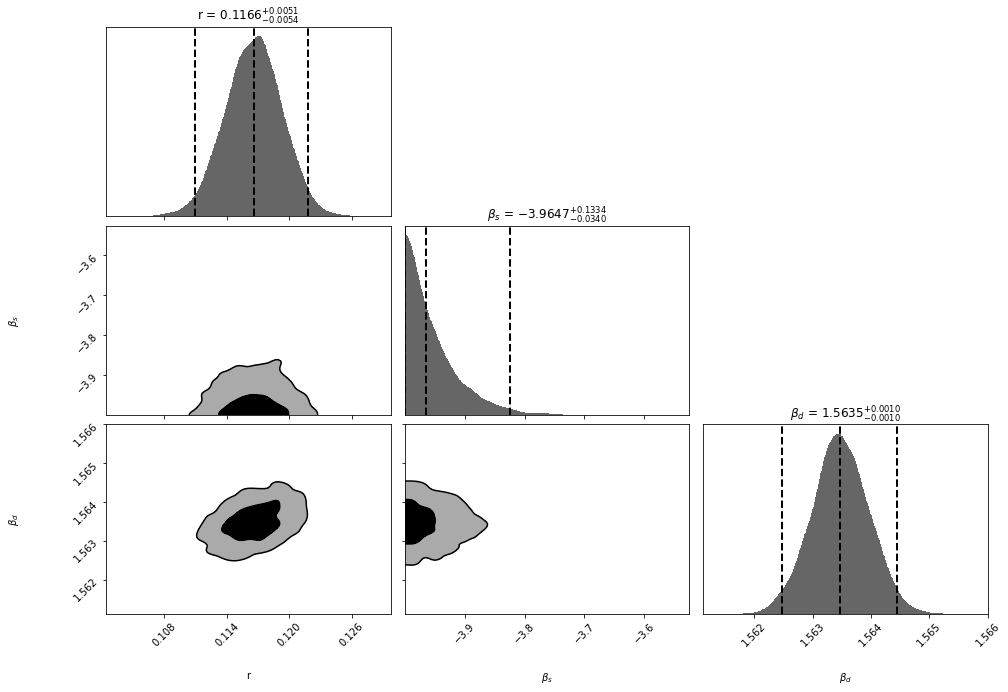

In [924]:
#[10]
labels = ['r', r'$\beta_s$',r'$\beta_d$', r'epislon']; 
fig, axes = plt.subplots(npara, npara, figsize=(15, 10))
axes = axes.reshape((npara, npara)) 

fig, ax = dyplot.cornerplot(results, truths=truth, fig = (fig, axes), title_fmt='.4f', show_titles=True,
                 labels = labels,quantiles = sig2, quantiles_2d = [0.4,0.85]) #0.1, 0.4, 0.65, 0.85

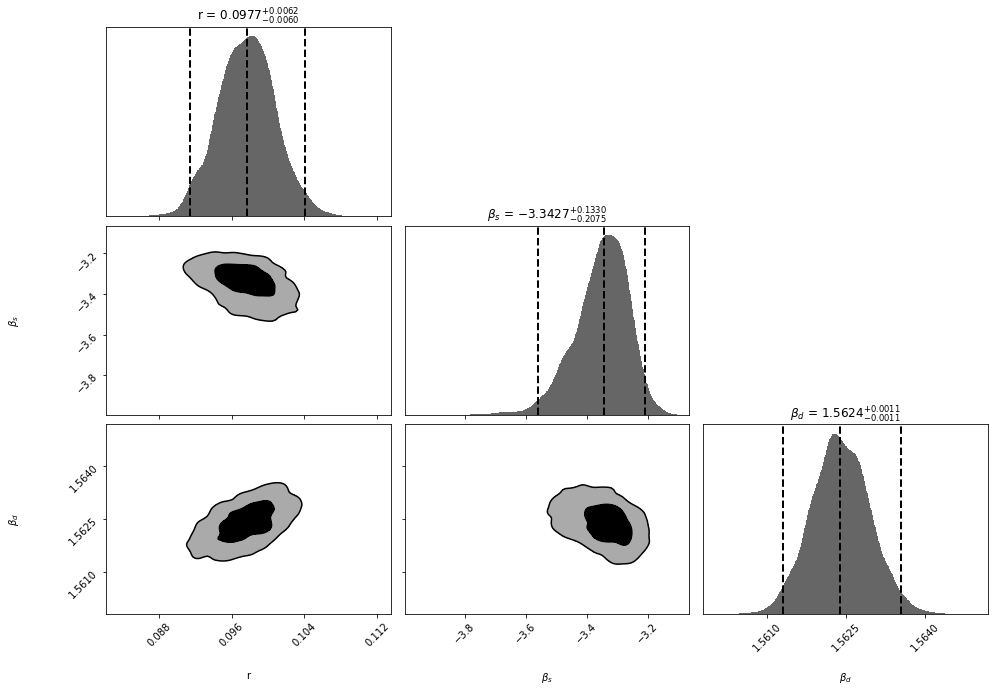

In [914]:
#[11]
labels = ['r', r'$\beta_s$',r'$\beta_d$', r'epislon']; 
fig, axes = plt.subplots(npara, npara, figsize=(15, 10))
axes = axes.reshape((npara, npara)) 

fig, ax = dyplot.cornerplot(results, truths=truth, fig = (fig, axes), title_fmt='.4f', show_titles=True,
                 labels = labels,quantiles = sig2, quantiles_2d = [0.4,0.85]) #0.1, 0.4, 0.65, 0.85

# plt.savefig('./fig_results/dynesty/0713_cl_hat_r_0p05_fiducial_only_CMB_r0p05_noise.pdf', format = 'pdf')

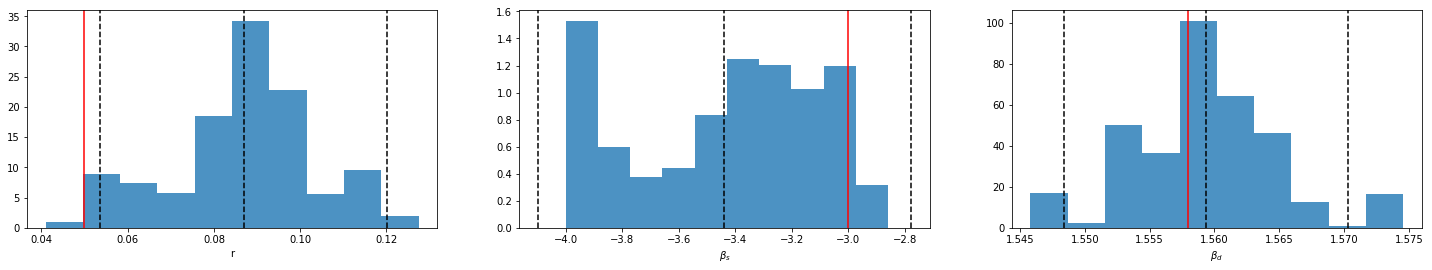

In [900]:
resamples = dyfunc.resample_equal(samples, weights)

fig, axes = plt.subplots(1,npara, figsize = (25,4))

for m in range(npara):
    
    axes[m].hist(resamples[:,m], density=True, alpha = 0.8); 
    axes[m].axvline(truth[m], c = 'r')
    axes[m].axvline(np.mean(resamples[:,m]),c = 'k', ls = '--')
    axes[m].axvline(np.mean(resamples[:,m] +2*np.std(resamples[:,m])),c = 'k', ls = '--')
    axes[m].axvline(np.mean(resamples[:,m] - 2*np.std(resamples[:,m])),c = 'k', ls = '--')
    axes[m].set_xlabel(r'%s'%labels[m])

##### include epsilon

In [903]:
np.std(resamples[:,0])

0.01661199150956583

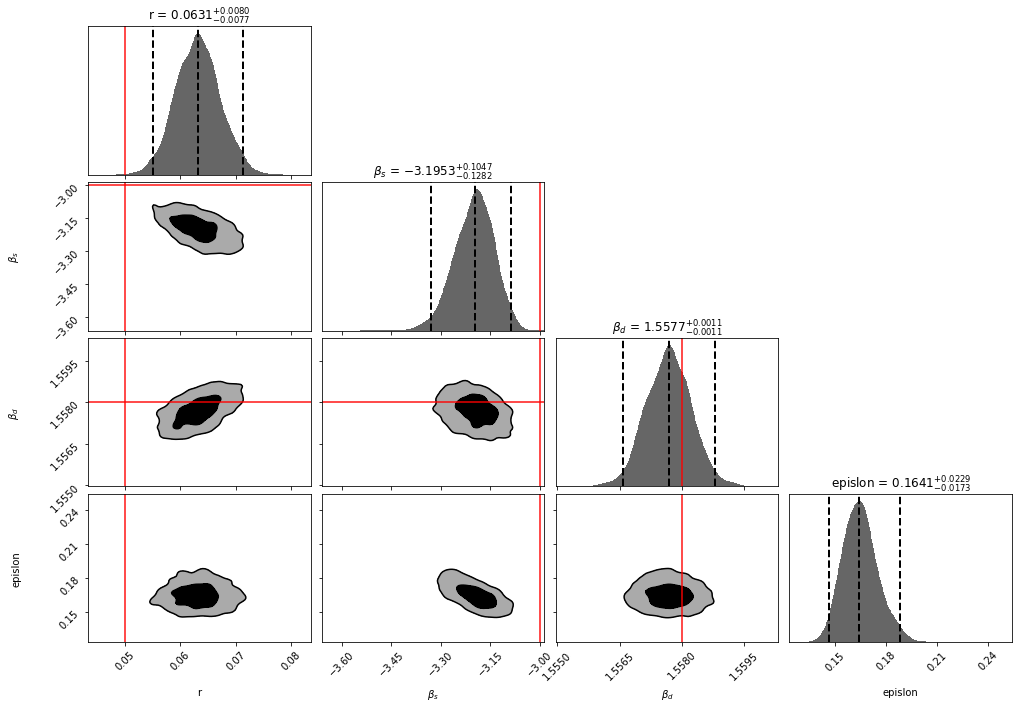

In [917]:
#[10]
labels = ['r', r'$\beta_s$',r'$\beta_d$', r'epislon']; 
fig, axes = plt.subplots(npara, npara, figsize=(15, 10))
axes = axes.reshape((npara, npara)) 

fig, ax = dyplot.cornerplot(results, truths=truth, fig = (fig, axes), title_fmt='.4f', show_titles=True,
                 labels = labels,quantiles = sig2, quantiles_2d = [0.4,0.85]) #0.1, 0.4, 0.65, 0.85

# plt.savefig('./fig_results/dynesty/0713_cl_hat_r_0p05_fiducial_only_CMB_r0p05_noise.pdf', format = 'pdf')

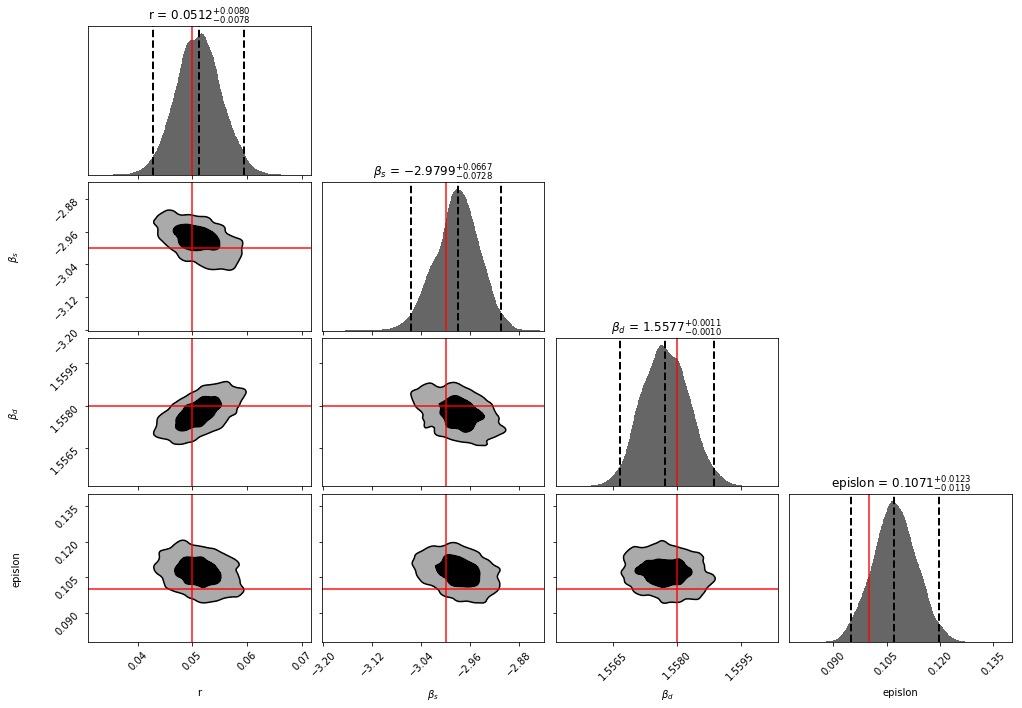

In [912]:
#[11]
labels = ['r', r'$\beta_s$',r'$\beta_d$', r'epislon']; 
fig, axes = plt.subplots(npara, npara, figsize=(15, 10))
axes = axes.reshape((npara, npara)) 

fig, ax = dyplot.cornerplot(results, truths=truth, fig = (fig, axes), title_fmt='.4f', show_titles=True,
                 labels = labels,quantiles = sig2, quantiles_2d = [0.4,0.85]) #0.1, 0.4, 0.65, 0.85

# plt.savefig('./fig_results/dynesty/0713_cl_hat_r_0p05_fiducial_only_CMB_r0p05_noise.pdf', format = 'pdf')

/home/jianyao/anaconda3/lib/python3.7/site-packages/dynesty/utils.py:163: UserWarning: Weights do not sum to 1 and have been renormalized.
  warnings.warn("Weights do not sum to 1 and have been renormalized.")


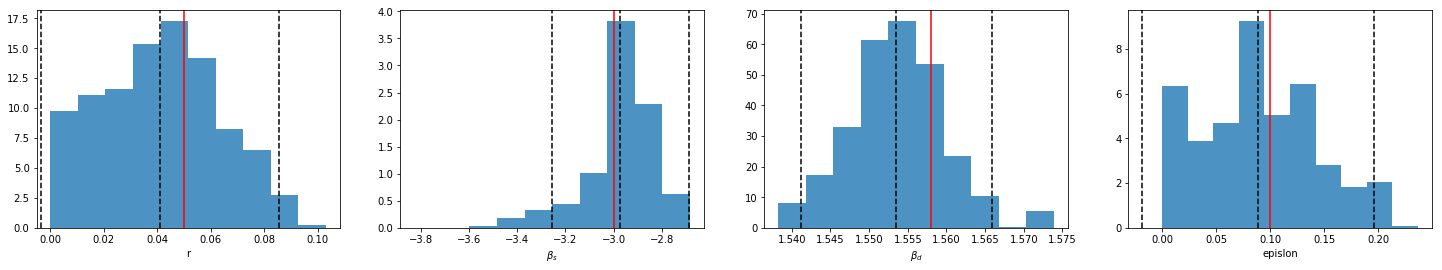

In [919]:
### include epsilon

resamples = dyfunc.resample_equal(samples, weights)

fig, axes = plt.subplots(1,npara, figsize = (25,4))

for m in range(npara):
    
    axes[m].hist(resamples[:,m], density=True, alpha = 0.8); 
    axes[m].axvline(truth[m], c = 'r')
    axes[m].axvline(np.mean(resamples[:,m]),c = 'k', ls = '--')
    axes[m].axvline(np.mean(resamples[:,m] +2*np.std(resamples[:,m])),c = 'k', ls = '--')
    axes[m].axvline(np.mean(resamples[:,m] - 2*np.std(resamples[:,m])),c = 'k', ls = '--')
    axes[m].set_xlabel(r'%s'%labels[m])

In [920]:
np.std(resamples[:,0])

0.0223283006791414

#### (cl + fl) as new cl

In this case, foreground are treated as a kind of new noise, and increase the error.

(<Figure size 1080x720 with 9 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1701beabe0>,
       dtype=object))

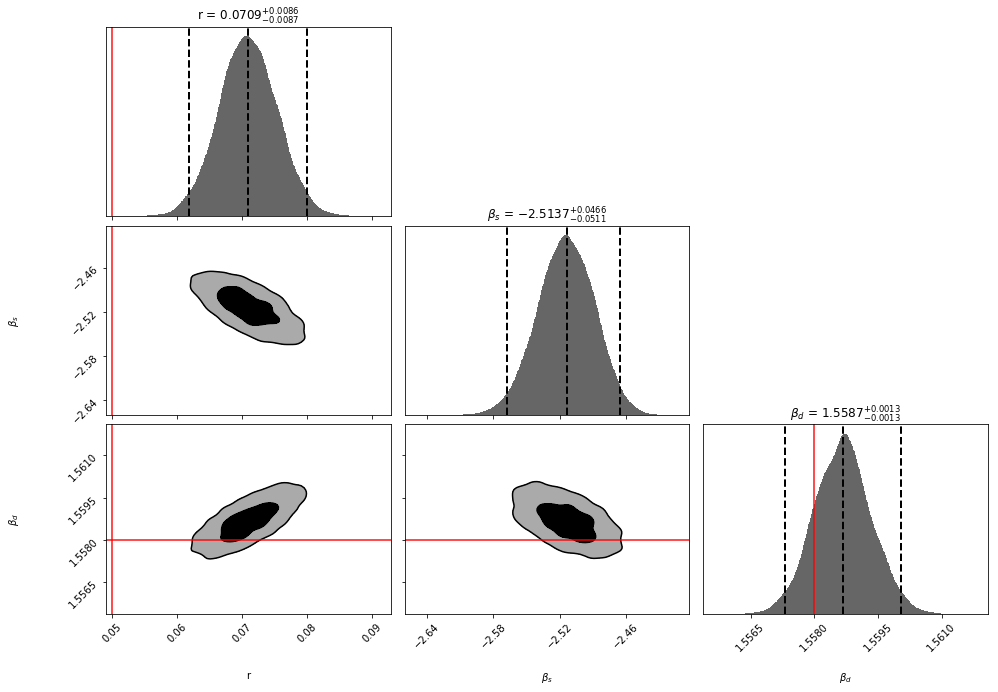

In [53]:
### fiducial bandpowers include both dust and synchrotron

labels = ['r',r'$\beta_s$',r'$\beta_d$']
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
axes = axes.reshape((3, 3)) 

dyplot.cornerplot(results, truths=truth, fig = (fig, axes), title_fmt='.4f', show_titles=True,
                 labels = labels,quantiles = sig2, quantiles_2d = [0.4,0.85]) #0.1, 0.4, 0.65, 0.85
# plt.savefig('./fig_results/dynesty/cl+fl_beta_s_n3p3_beta_d_1p59_new_units_2sigma.pdf', format = 'pdf')

(<Figure size 1080x720 with 9 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1702de57f0>,
       dtype=object))

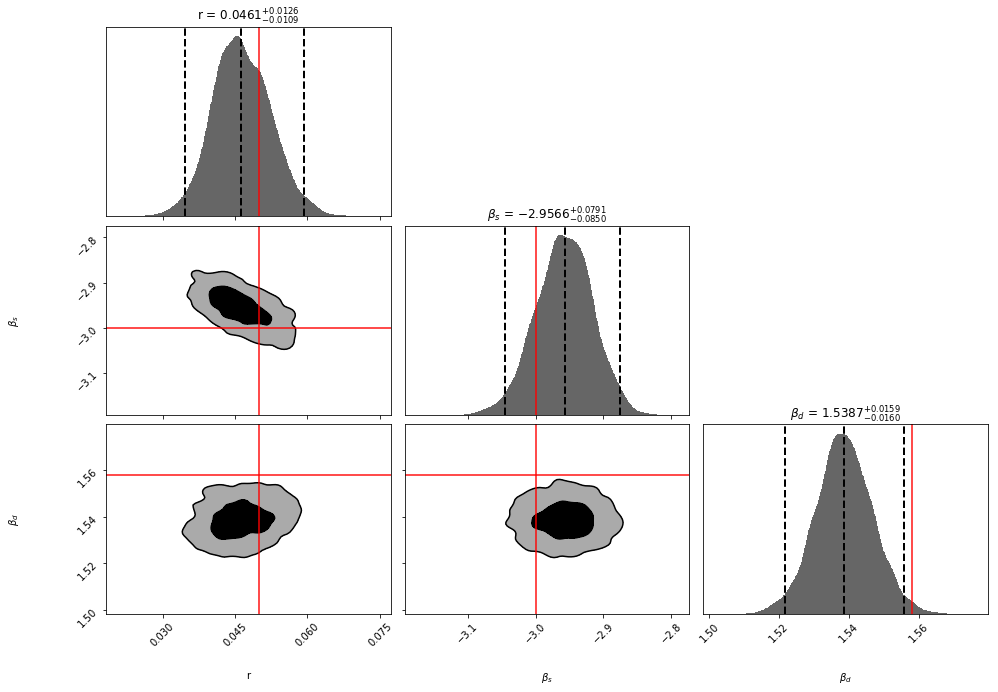

In [49]:
### fiducial banpowers include synchrotron only

labels = ['r',r'$\beta_s$',r'$\beta_d$']
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
axes = axes.reshape((3, 3)) 

dyplot.cornerplot(results, truths=truth, fig = (fig, axes), title_fmt='.4f', show_titles=True,
                 labels = labels,quantiles = sig2, quantiles_2d = [0.4,0.85]) #0.1, 0.4, 0.65, 0.85
# plt.savefig('./fig_results/dynesty/cl+fl_beta_s_n3p3_beta_d_1p59_new_units_2sigma.pdf', format = 'pdf')

#### (cl_hat - fl ) as new cl_hat

(<Figure size 1080x720 with 9 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa2aabab3c8>,
       dtype=object))

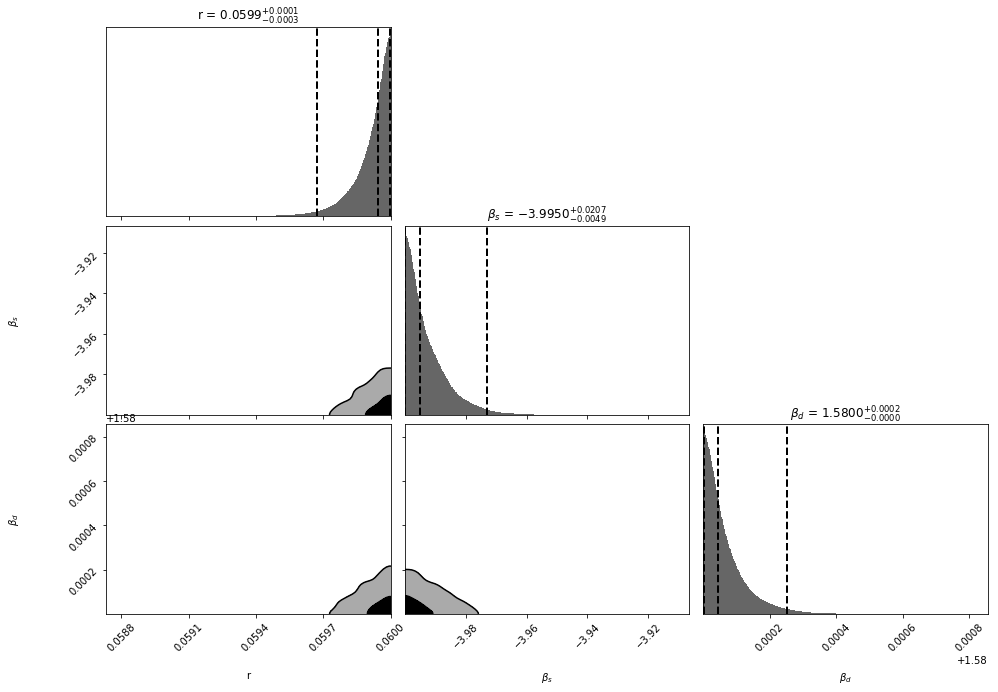

In [2404]:
labels = ['r',r'$\beta_s$',r'$\beta_d$']
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
axes = axes.reshape((3, 3)) 

dyplot.cornerplot(results,  truths=truth, fig = (fig, axes), title_fmt='.4f', show_titles=True,
                 labels = labels,quantiles = sig2, quantiles_2d = [0.4,0.85]) #0.1, 0.4, 0.65, 0.85

# plt.savefig('./fig_results/dynesty/cl_hat-fl_beta_s_n3p3_beta_d_1p59_new_units_2sigma.pdf', format = 'pdf')

(<Figure size 1080x720 with 9 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa2ba8d89e8>,
       dtype=object))

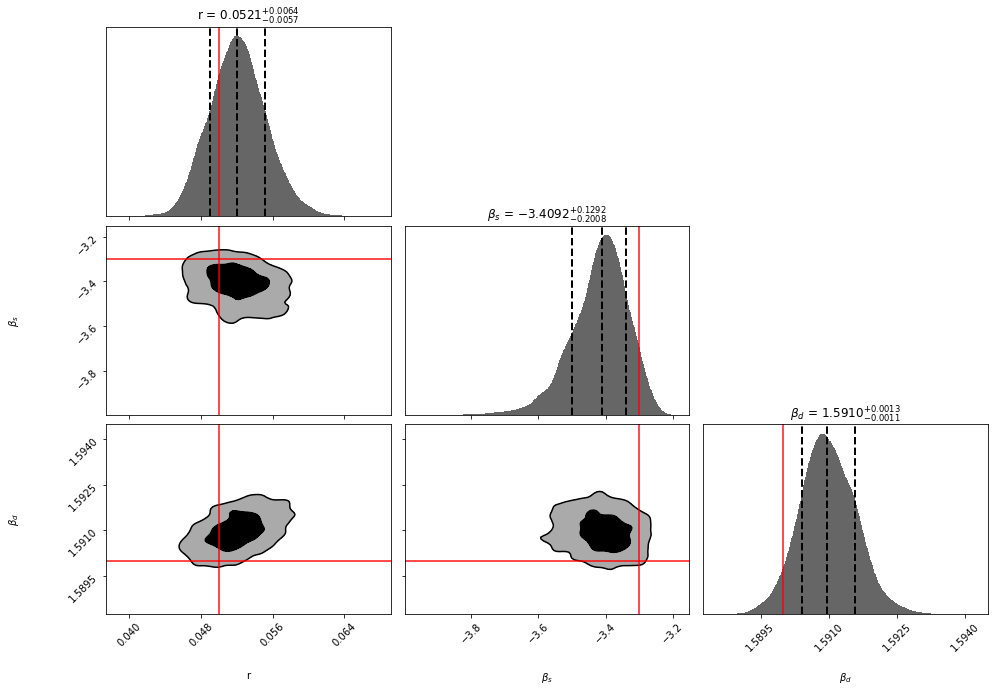

In [2298]:
labels = ['r',r'$\beta_s$',r'$\beta_d$']
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
axes = axes.reshape((3, 3)) 

dyplot.cornerplot(results,  truths=truth, fig = (fig, axes), title_fmt='.4f', show_titles=True,
                 labels = labels,quantiles = sig1, quantiles_2d = [0.4,0.85]) #0.1, 0.4, 0.65, 0.85

# plt.savefig('./fig_results/dynesty/cl_hat-fl_beta_s_n3p3_beta_d_1p59_new_units.pdf', format = 'pdf')

In [1532]:
from dynesty import utils as dyfunc 

samples, weights = results.samples, np.exp(results.logwt - results.logz[-1])
mean, cov = dyfunc.mean_and_cov(samples, weights) 

In [1533]:
mean

array([0.05038273])

In [1513]:
np.sqrt(cov)

array([[0.00118992]])

## Test evaluate likelihood function

In [1733]:
from utils import calc_vecp as calc_vecp